In [112]:
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import math
from concurrent.futures import ProcessPoolExecutor
from joblib import Parallel, delayed
from sklearn.metrics import confusion_matrix
import numpy as np
from tqdm import tqdm
import seaborn as sns
import numpy as np
from scipy.stats import kruskal
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import mannwhitneyu

Sort order is unique for each bean instance so we drop it.

In [113]:
path = 'DryBeanDataSet.xlsx'
# path = 'data/NormalizedDryBeanDataSet.xlsx'
df = pd.read_excel(path)
mask = df.apply(lambda row: any(cell == '?' for cell in row), axis=1)
df_cleaned = df[~mask]
categorical_cols = ['Constantness', 'Colour', 'Class']
df = df.drop(columns=['Sort order'])
df = df[df['Class'] != '?']
print(df['Class'].value_counts())

# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Drop rows with any NaN values
df.dropna(inplace=True)

Class
DERMASON    3542
SIRA        2634
SEKER       2025
HOROZ       1927
CALI        1628
BARBUNYA    1317
BOMBAY       521
Name: count, dtype: int64


C:\Users\neilb\AppData\Local\Temp\ipykernel_6376\3939796568.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('?', np.nan, inplace=True)


# Impute Missing values:

In [180]:
# Impute missing values:
cols = ['Extent', 'Compactness', 'ShapeFactor6']
for col in cols:
    df[col] = df[col].replace('?', np.nan)
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

df['Colour'] = df['Colour'].replace('?', np.nan)
median_value = df['Colour'].mode()
df['Colour'] = df['Colour'].fillna(median_value)

for col in df.columns:
    print(df[col].value_counts())

Area
47134    4
36109    4
38542    4
38426    4
34774    4
        ..
53447    1
39733    1
39313    1
46638    1
64235    1
Name: count, Length: 11995, dtype: int64
Perimeter
911.589     3
805.168     3
984.123     3
701.644     3
683.341     3
           ..
783.344     1
594.833     1
1496.093    1
766.745     1
734.947     1
Name: count, Length: 13334, dtype: int64
MajorAxisLength
397.793919    2
375.980183    2
372.954622    2
332.068530    2
331.843270    2
             ..
287.622587    1
228.296004    1
429.252926    1
267.212010    1
278.316950    1
Name: count, Length: 13526, dtype: int64
MinorAxisLength
189.528762    2
174.907355    2
186.450123    2
171.958309    2
176.276767    2
             ..
186.009292    1
163.728085    1
230.136242    1
217.585334    1
179.575513    1
Name: count, Length: 13526, dtype: int64
AspectRation
2.098858    2
2.149596    2
2.000292    2
1.931099    2
1.882513    2
           ..
1.546281    1
1.394361    1
1.865212    1
1.228079    1
1.549860 

C:\Users\neilb\AppData\Local\Temp\ipykernel_7372\797759242.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace('?', np.nan)


In [29]:
df = df.drop(3909)
df = df.reset_index(drop=True)
print(df['ConvexArea'].idxmin())
print(df.shape)
# df['EquivDiameter'].max()

3748
(13556, 21)


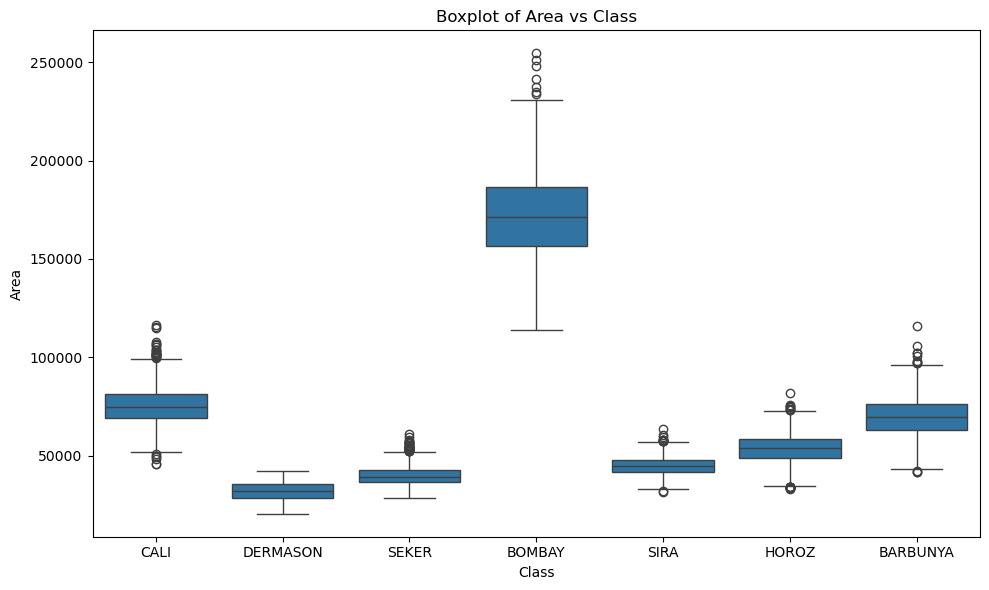

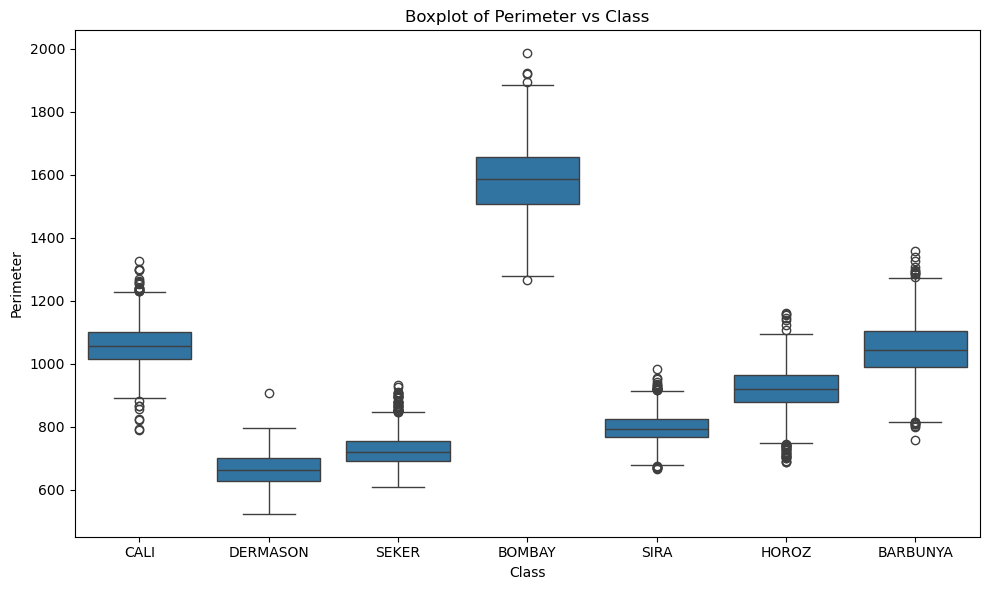

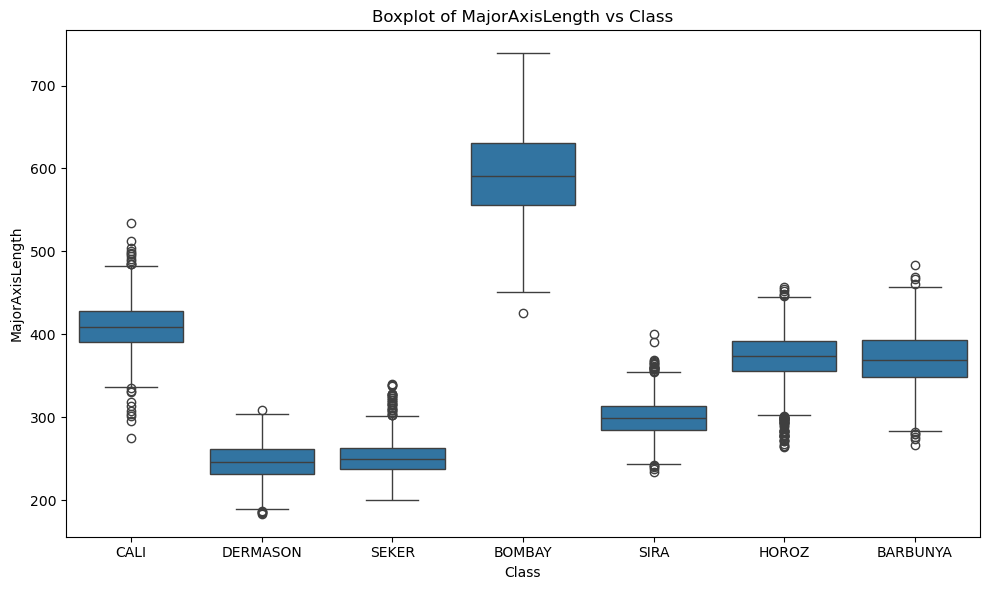

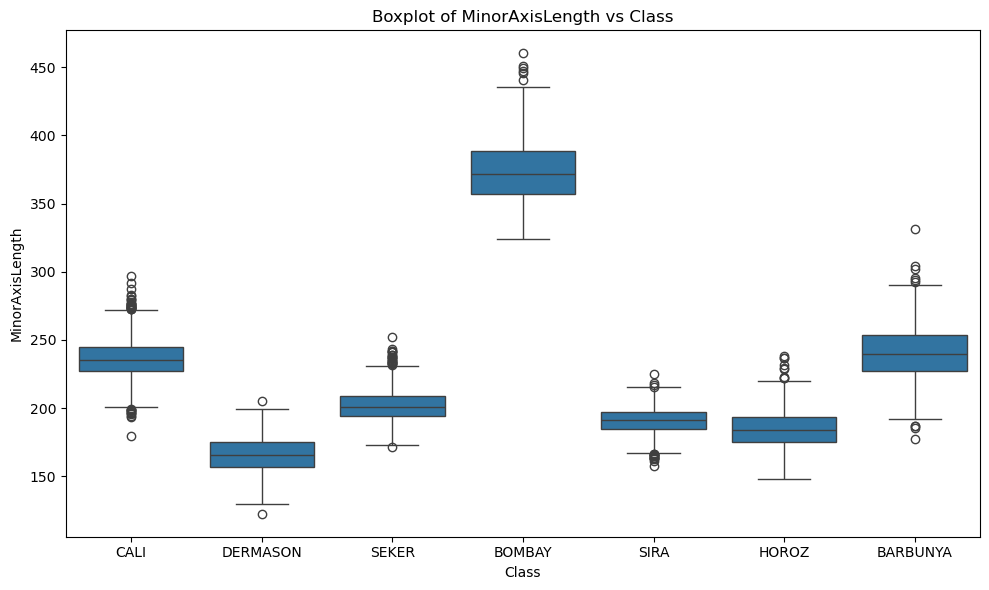

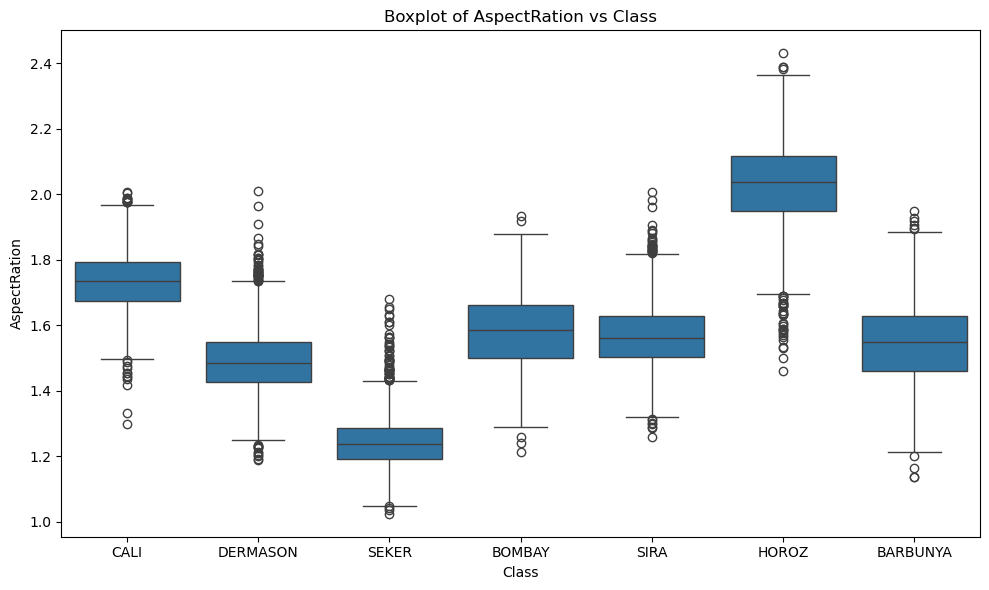

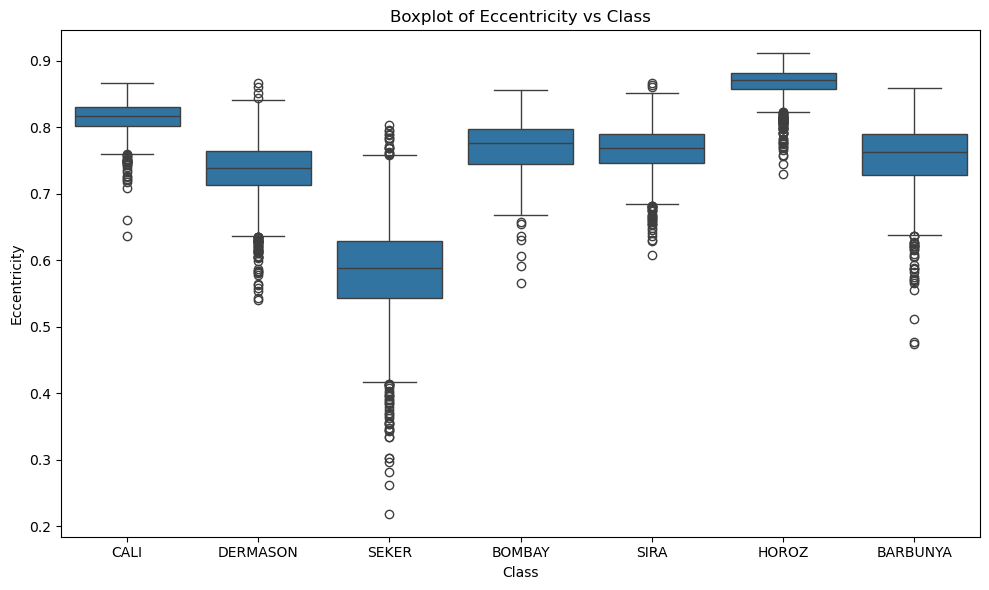

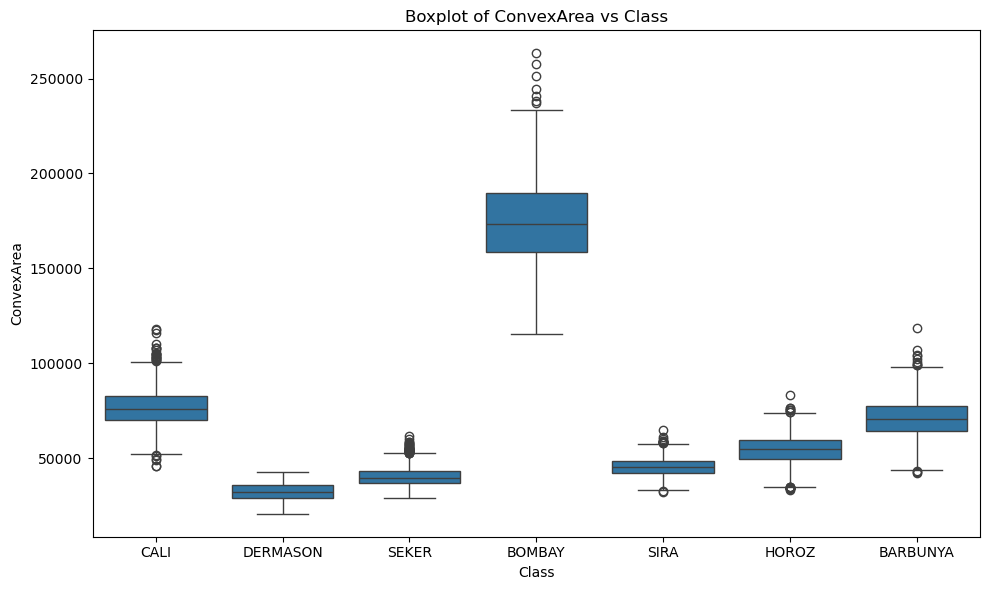

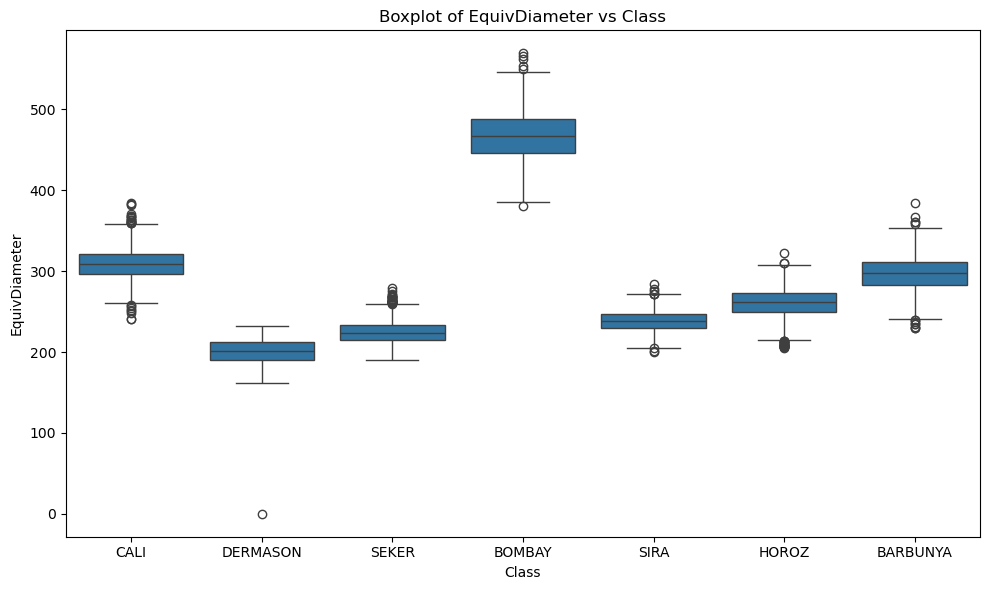

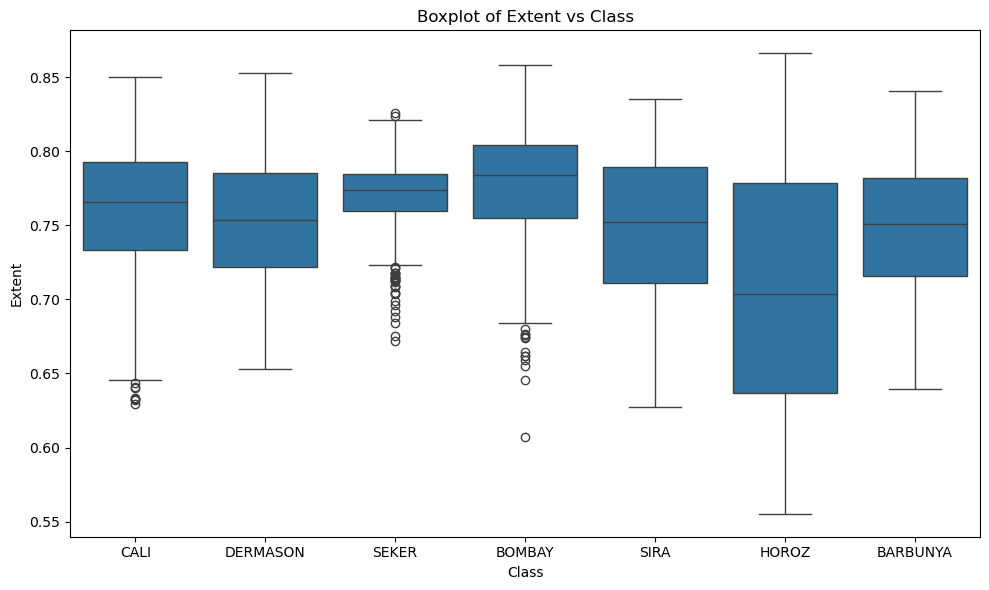

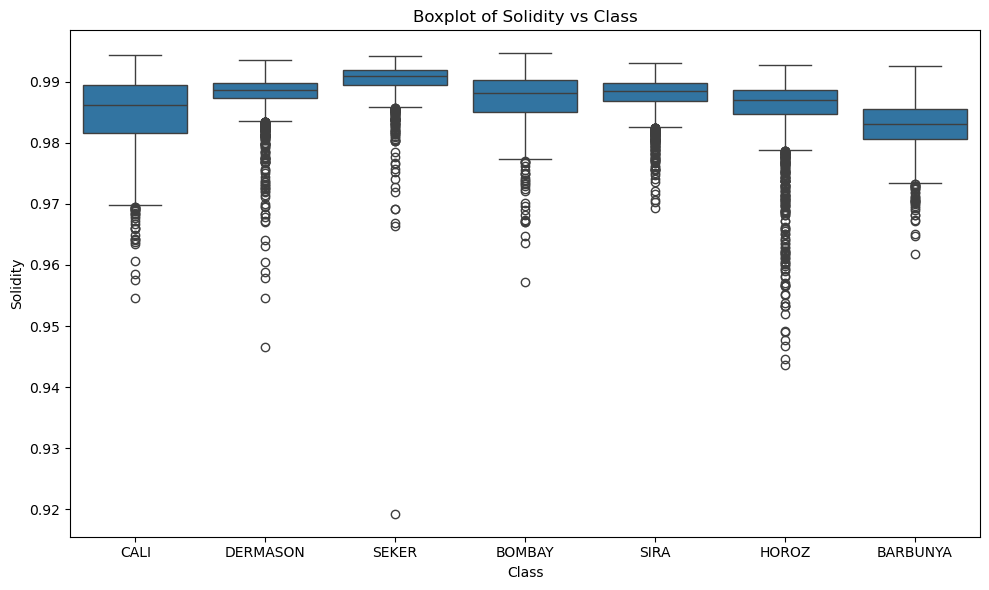

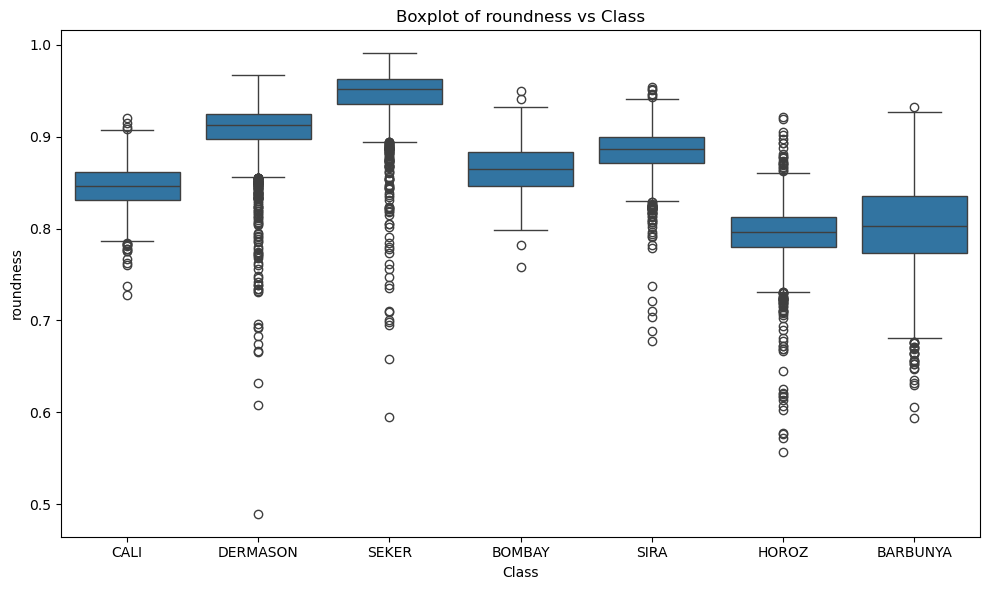

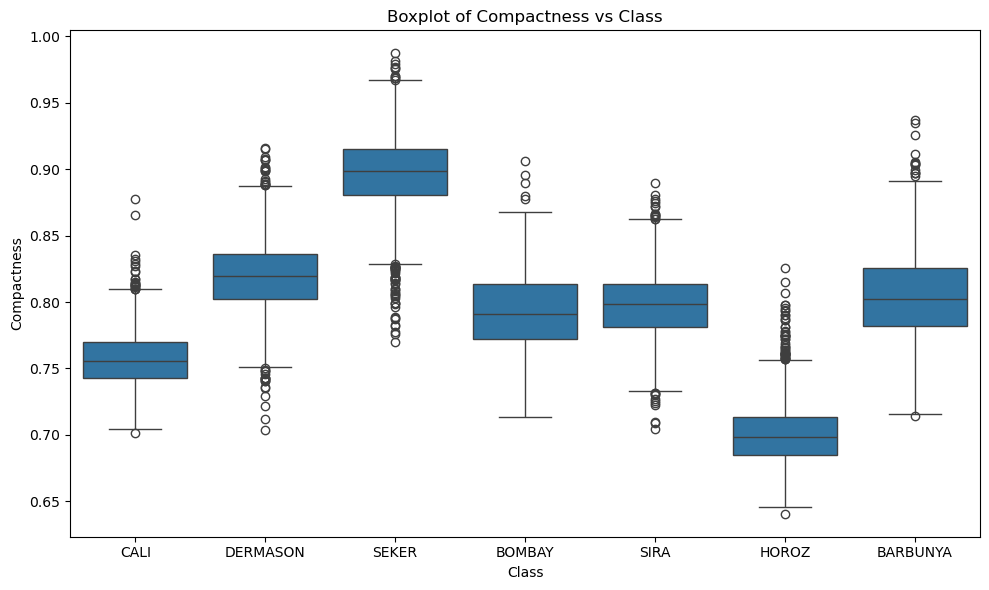

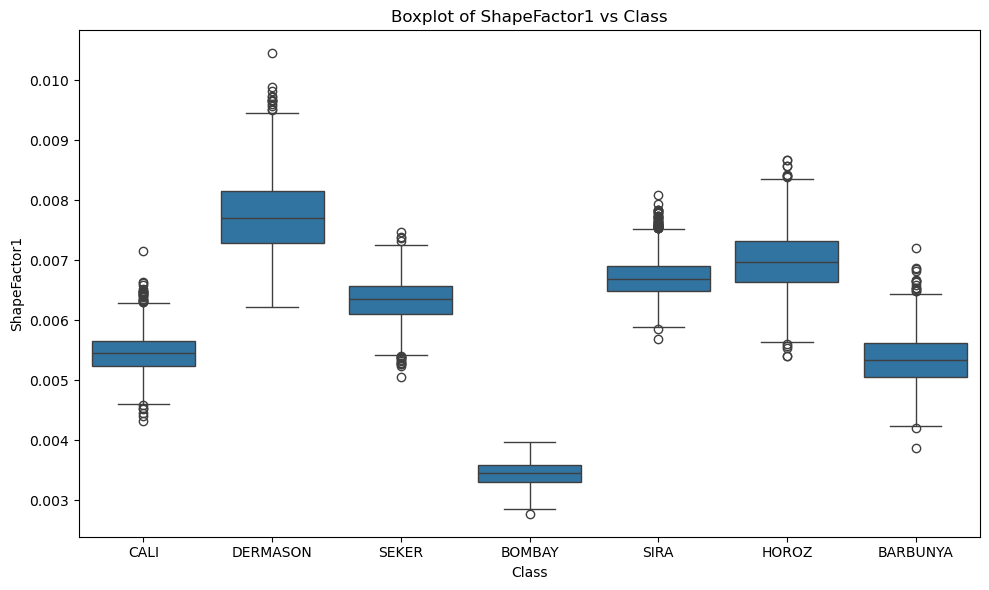

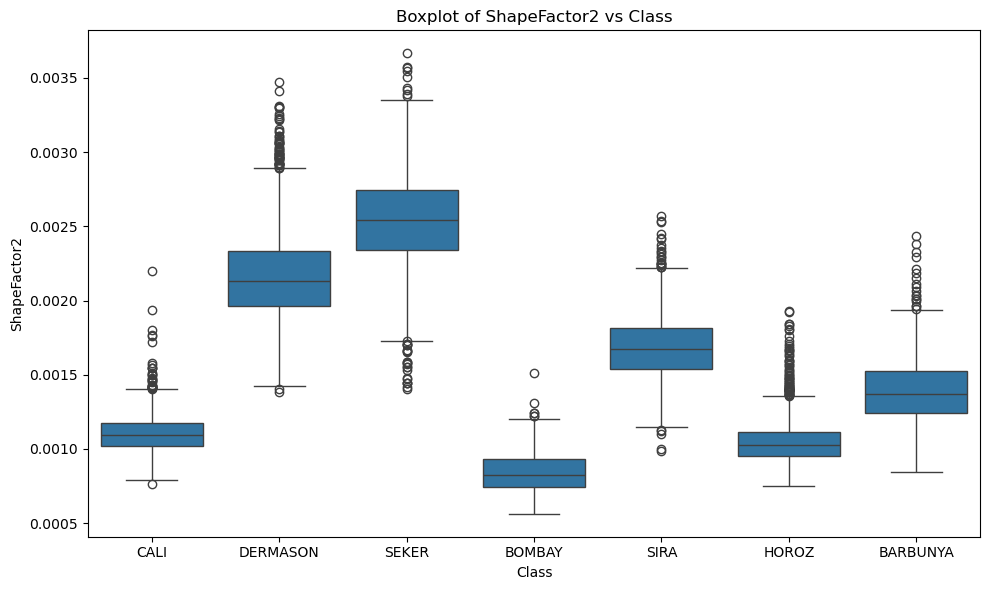

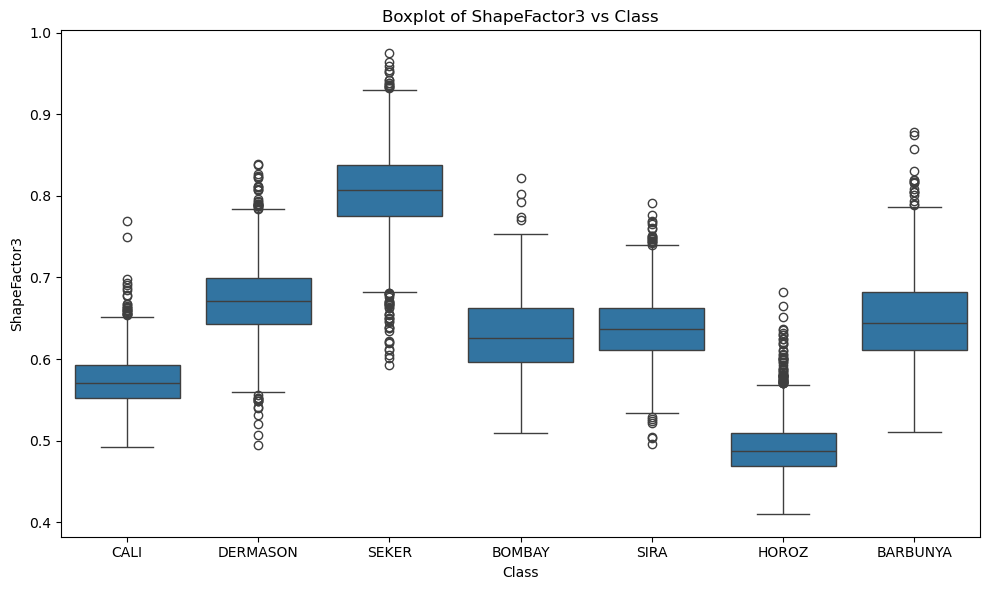

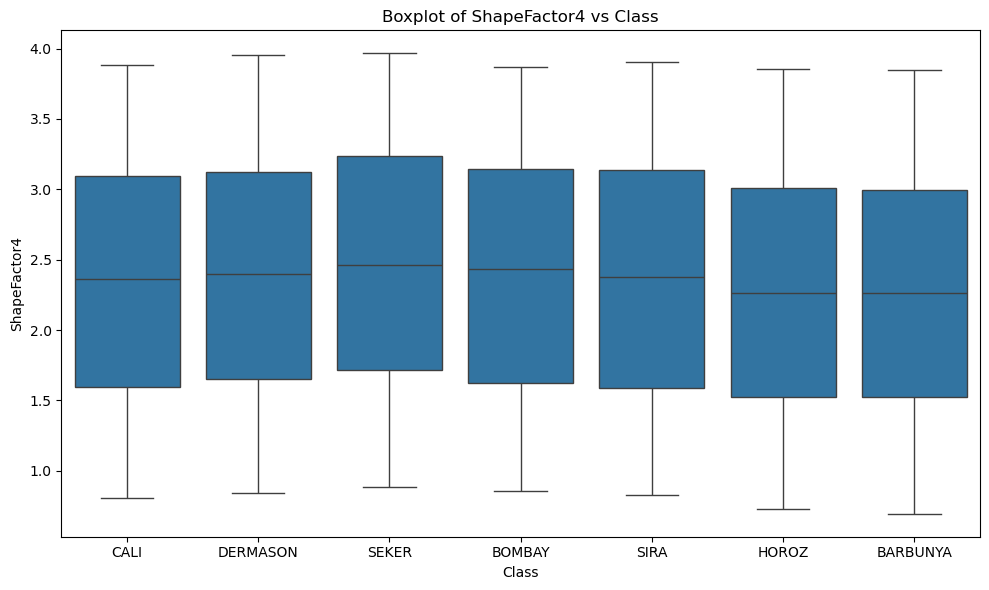

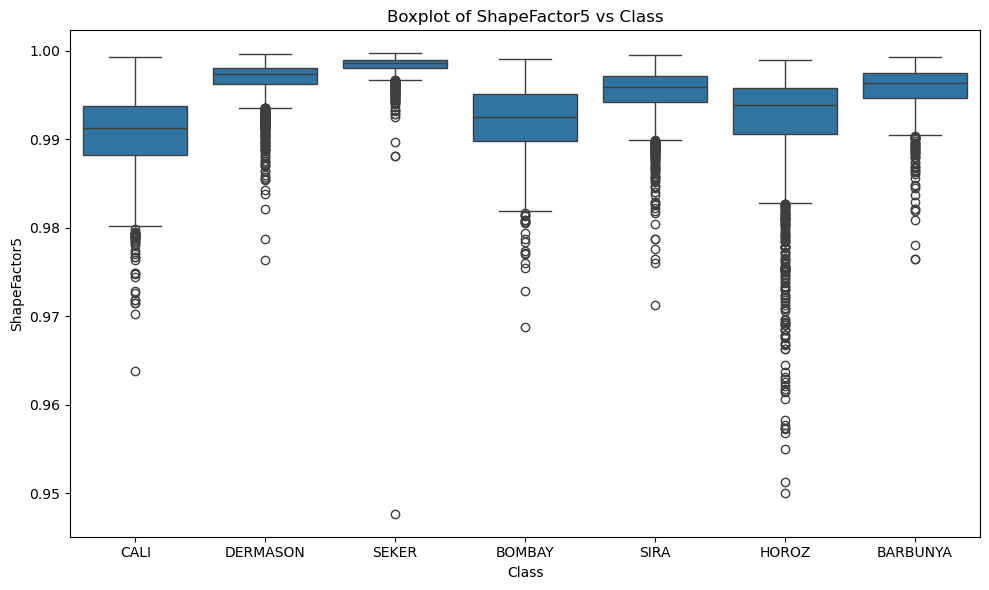

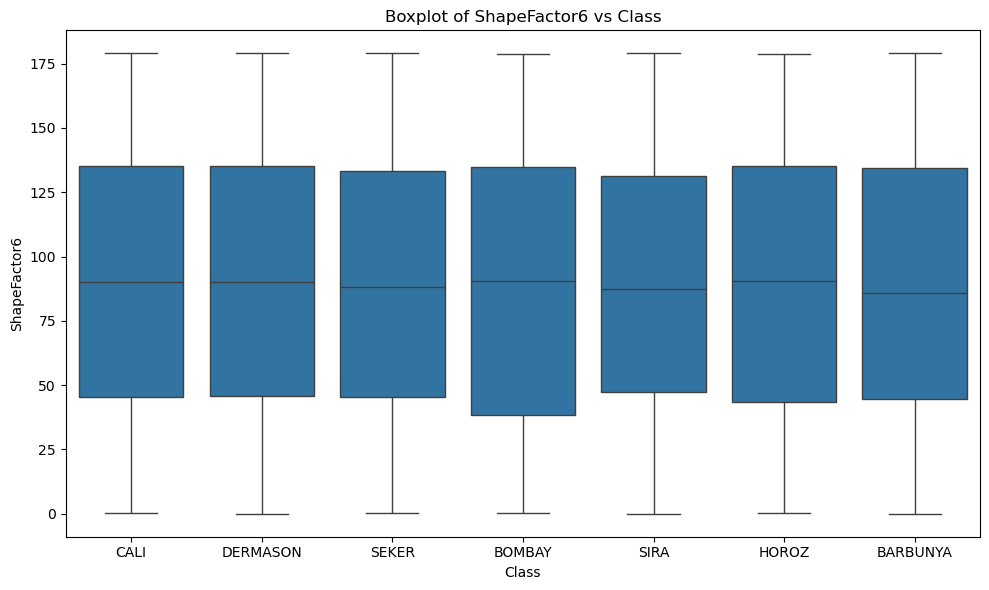

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
features = df.columns.drop(['Class', 'Colour', 'Constantness'])

# plt.figure(figsize=(20, 30))

for i, feature in enumerate(features):
    # plt.subplot(7, 3, i+1)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Class', y=feature, data=df)
    plt.title(f'Boxplot of {feature} vs Class')
    plt.tight_layout()
    plt.savefig(f"{feature}boxplot.png")

# plt.savefig("TotalBoxPLots.png")
plt.show()

In [114]:
df_encoded = pd.get_dummies(df, columns=['Colour'], dtype=float)
df_encoded.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Extent,...,ShapeFactor2,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class,Colour_black,Colour_brown,Colour_green,Colour_white
0,84648,1132.054,439.915710,248.961941,1.767000,0.824453,86779,1,328.294351,0.767184,...,0.000994,0.556914,3.487008,0.984066,50.809833,CALI,0.0,1.0,0.0,0.0
1,39704,736.873,271.659919,186.481404,1.456767,0.727175,40106,1,224.839282,0.757739,...,0.001980,0.685004,1.242335,0.997891,148.508874,DERMASON,1.0,0.0,0.0,0.0
2,35835,687.914,237.704180,192.176759,1.236904,0.588537,36190,1,213.603696,0.790885,...,0.002668,0.807503,2.813489,0.998803,82.107117,SEKER,0.0,0.0,1.0,0.0
3,223035,1817.278,680.812555,419.994347,1.621004,0.787040,225889,1,532.894907,0.761092,...,0.000707,0.612672,3.074472,0.993144,147.347735,BOMBAY,0.0,1.0,0.0,0.0
4,41957,767.143,287.962974,186.166695,1.546802,0.762918,42310,1,231.130508,0.721543,...,0.001757,0.644230,2.213954,0.996497,22.893826,SIRA,0.0,1.0,0.0,0.0


In [5]:
# df['Class'] = df['Class'].astype("category")
df_encoded = pd.get_dummies(df, columns=['Colour'])

label = LabelEncoder()
df['Class'] = label.fit_transform(df['Class'])
df_encoded.dtypes
df_encoded.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,Constantness,EquivDiameter,Extent,...,ShapeFactor2,ShapeFactor3,ShapeFactor4,ShapeFactor5,ShapeFactor6,Class,Colour_black,Colour_brown,Colour_green,Colour_white
0,84648,1132.054,439.915710,248.961941,1.767000,0.824453,86779,1,328.294351,0.767184,...,0.000994,0.556914,3.487008,0.984066,50.809833,2,False,True,False,False
1,39704,736.873,271.659919,186.481404,1.456767,0.727175,40106,1,224.839282,0.757739,...,0.001980,0.685004,1.242335,0.997891,148.508874,3,True,False,False,False
2,35835,687.914,237.704180,192.176759,1.236904,0.588537,36190,1,213.603696,0.790885,...,0.002668,0.807503,2.813489,0.998803,82.107117,5,False,False,True,False
3,223035,1817.278,680.812555,419.994347,1.621004,0.787040,225889,1,532.894907,0.761092,...,0.000707,0.612672,3.074472,0.993144,147.347735,1,False,True,False,False
4,41957,767.143,287.962974,186.166695,1.546802,0.762918,42310,1,231.130508,0.721543,...,0.001757,0.644230,2.213954,0.996497,22.893826,6,False,True,False,False


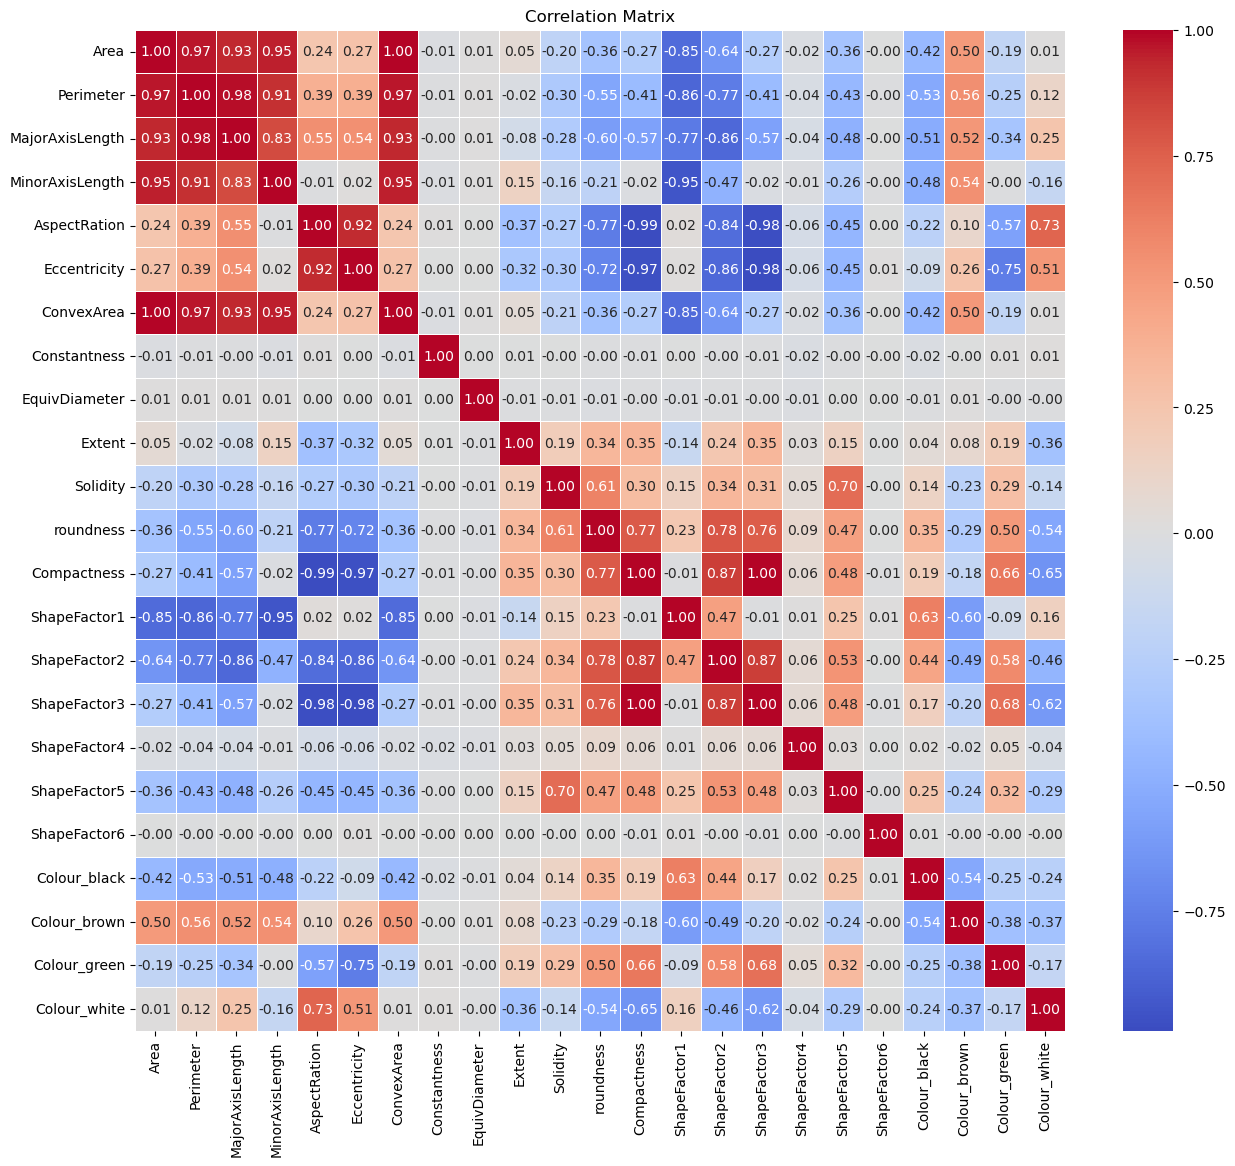

In [16]:
correlation_matrix = df_encoded.drop(columns=['Class']).corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.savefig("CorrelationMatrix.png")
plt.show()

# Apply SMOTE and Tomek

In [115]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

X = df_encoded.drop(columns=['Class'])
y = df_encoded['Class']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

tomek = TomekLinks()
X_resampled, y_resampled = tomek.fit_resample(X_resampled, y_resampled)

In [116]:
# print(X_resampled.info())
# print(y_resampled.value_counts())
print(y_resampled.value_counts())

Class
BARBUNYA    3535
BOMBAY      3533
HOROZ       3461
CALI        3435
SEKER       3396
DERMASON    3302
SIRA        3263
Name: count, dtype: int64


# Normalize data

In [117]:
from sklearn.model_selection import train_test_split

tmp_df = X_resampled.drop(columns=['Colour_black', 'Colour_brown', 'Colour_green', 'Colour_white', 'Constantness'])
tmp1_df = X_resampled[['Colour_black', 'Colour_brown', 'Colour_green', 'Colour_white', 'Constantness']]
# tmp_df = X.drop(columns=['Colour_black', 'Colour_brown', 'Colour_green', 'Colour_white', 'Constantness'])
# tmp1_df = X[['Colour_black', 'Colour_brown', 'Colour_green', 'Colour_white', 'Constantness']]

X_scaled = (tmp_df-tmp_df.mean())/tmp_df.std()

X_scaled = pd.concat([X_scaled, tmp1_df], axis=1)
print(X_scaled.head())

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size = 0.2, random_state = 1)
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

       Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation  \
0  0.300402   0.521352         0.647041         0.298802      0.681259   
1 -0.666978  -0.804750        -0.812167        -0.629128     -0.590597   
2 -0.750255  -0.969041        -1.106651        -0.544544     -1.491964   
3  3.279060   2.820746         2.736234         2.838892      0.082723   
4 -0.618484  -0.703174        -0.670778        -0.633802     -0.221482   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  ...  \
0      0.746287    0.321043      -0.011720  0.322425 -2.412825  ...   
1     -0.328947   -0.669912      -0.014709  0.120512  0.677284  ...   
2     -1.861359   -0.753056      -0.015033  0.829103  0.722806  ...   
3      0.332758    3.274608      -0.005810  0.192197  0.122103  ...   
4      0.066127   -0.623117      -0.014527 -0.653277  1.034547  ...   

   ShapeFactor2  ShapeFactor3  ShapeFactor4  ShapeFactor5  ShapeFactor6  \
0     -0.869721     -0.811552      1.413765     -2.39

In [97]:
# n_features = X_train.shape[1]

# remaining_features = list(X.columns)
# best_models = []

# i = 0
# for k in tqdm(range(n_features, 1, -1), desc="Algo"):
#     rss_list = []
#     models = []

#     for feature in remaining_features:
#         features = [f for f in remaining_features if f != feature]
#         X_train_subset = X_train[features]
#         X_test_subset = X_test[features]

#         knn = KNeighborsClassifier(n_neighbors=135, weights='uniform')
#         knn.fit(X_train_subset, y_train)
#         y_subset_pred = knn.predict(X_test_subset)

#         rss = np.sum((y_test - y_subset_pred) ** 2)
#         rss_list.append(rss)
#         models.append((features, feature))

#     best_rss = min(rss_list)
#     best_model, removed_feature = models[rss_list.index(best_rss)]

#     best_models.append((best_model, removed_feature, best_rss))

#     remaining_features = best_model


n_features = X_train.shape[1]

remaining_features = list(X.columns)
best_models = []

for k in tqdm(range(n_features, 1, -1), desc="Feature Selection"):
    accuracy_list = []
    models = []

    for feature in remaining_features:
        features = [f for f in remaining_features if f != feature]
        X_train_subset = X_train[features]
        X_test_subset = X_test[features]

        knn = KNeighborsClassifier(n_neighbors=135, weights='uniform')
        knn.fit(X_train_subset, y_train)
        y_subset_pred = knn.predict(X_test_subset)

        accuracy = accuracy_score(y_test, y_subset_pred)
        accuracy_list.append(accuracy)
        models.append((features, feature))

    best_accuracy = max(accuracy_list)
    best_model, removed_feature = models[accuracy_list.index(best_accuracy)]

    best_models.append((best_model, removed_feature, best_accuracy))

    remaining_features = best_model

Feature Selection: 100%|███████████████████████████████████████████████████████████████| 22/22 [03:19<00:00,  9.06s/it]


In [98]:
for bm in best_models:
    print(bm)

(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'Constantness', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor5', 'ShapeFactor6', 'Colour_black', 'Colour_brown', 'Colour_green', 'Colour_white'], 'ShapeFactor4', 0.9765935214211077)
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'Constantness', 'EquivDiameter', 'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor5', 'Colour_black', 'Colour_brown', 'Colour_green', 'Colour_white'], 'ShapeFactor6', 0.9786833855799373)
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', 'Eccentricity', 'ConvexArea', 'Constantness', 'EquivDiameter', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor5', 'Colour_black', 'Colour_brown'

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

num_features = 22
for bm in best_models:
    print(num_features)
    k = 135  # Number of neighbors
    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train[bm[0]], y_train)
    y_train_pred = knn.predict(X_train[bm[0]])
    y_test_pred = knn.predict(X_test[bm[0]])
    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # class_report = classification_report(y_test, y_pred)

    # print(f"Train Accuracy: {train_accuracy}")
    # print(f"Test Accuracy: {test_accuracy}")
    print('Training accuracy:', np.mean(knn.predict(X_train[bm[0]]) == y_train)*100)
    print('Test accuracy:', np.mean(knn.predict(X_test[bm[0]]) == y_test)*100)
    # print("Classification Report:\n", class_report)
    num_features -= 1

22
Training accuracy: 97.47126436781609
Test accuracy: 97.65935214211076
21
Training accuracy: 97.74817136886102
Test accuracy: 97.86833855799372
20
Training accuracy: 97.96238244514106
Test accuracy: 98.0773249738767
19
Training accuracy: 97.9362591431557
Test accuracy: 98.1400208986416
18
Training accuracy: 98.01462904911182
Test accuracy: 98.18181818181819
17
Training accuracy: 98.07210031347962
Test accuracy: 98.34900731452456
16
Training accuracy: 98.11912225705329
Test accuracy: 98.36990595611286
15
Training accuracy: 98.17659352142111
Test accuracy: 98.36990595611286
14
Training accuracy: 98.17659352142111
Test accuracy: 98.36990595611286
13
Training accuracy: 98.17136886102404
Test accuracy: 98.34900731452456
12
Training accuracy: 98.20794148380355
Test accuracy: 98.32810867293625
11
Training accuracy: 98.17659352142111
Test accuracy: 98.30721003134796
10
Training accuracy: 98.00940438871474
Test accuracy: 98.26541274817137
9
Training accuracy: 97.94670846394983
Test accuracy: 

In [38]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import matplotlib.pyplot as plt

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

k_values = [135]  # Example values of k for hyperparameter tuning

# Initialize storage for plotting
mean_val_scores_by_k = {k: [] for k in k_values}
std_val_scores_by_k = {k: [] for k in k_values}
num_features_list = []

mean_scores_plot = []
std_scores_plot = []

for bm in tqdm(best_models, desc="algo"):
    tmp_scores = []
    num_features = len(bm[0])
    num_features_list.append(num_features)
    
    # Set up the parameter grid for GridSearchCV
    param_grid = {'n_neighbors': k_values}

    # Initialize the KNeighborsClassifier
    knn = KNeighborsClassifier(weights='uniform')

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=kfold, scoring='accuracy', return_train_score=True)
    
    # Fit GridSearchCV on the training data
    grid_search.fit(X_train[bm[0]], y_train)
    
    # Extract results from the GridSearchCV
    results = grid_search.cv_results_
    print(results)
    print(bm) # 0.98077287
    tmp_scores.append(results['split0_test_score'])
    tmp_scores.append(results['split1_test_score'])
    tmp_scores.append(results['split2_test_score'])
    tmp_scores.append(results['split3_test_score'])
    tmp_scores.append(results['split4_test_score'])
    # tmp_scores.append(results['split5_test_score'])
    # tmp_scores.append(results['split6_test_score'])
    # tmp_scores.append(results['split7_test_score'])
    # tmp_scores.append(results['split8_test_score'])
    # tmp_scores.append(results['split9_test_score'])
    tmp_scores = np.array(tmp_scores)
    print((1-tmp_scores).mean())
    print((1-tmp_scores).std()/np.sqrt(5))

    mean_scores_plot.append((1-tmp_scores).mean())
    std_scores_plot.append((1-tmp_scores).std()/np.sqrt(5))

    # Store mean and standard deviation of accuracies for each k
    for k in k_values:
        mean_val_scores_by_k[k].append(results['mean_test_score'][k_values.index(k)])
        std_val_scores_by_k[k].append(results['std_test_score'][k_values.index(k)])

# Plot the results
# plt.figure(figsize=(10, 6))
print(f"mean_val_scores_by_k[k]: {(1 - np.array(mean_val_scores_by_k[k])).mean()}")
print(f"std_val_scores_by_k[k]: {(1 - np.array(mean_val_scores_by_k[k])).std()}")
print(f"len x: {len(num_features_list)}")
print(f"len y: {np.array(mean_val_scores_by_k)}")

for k in k_values:
    # plt.errorbar(num_features_list, (1 - np.array(mean_val_scores_by_k[k])).mean(), yerr=(1 - np.array(mean_val_scores_by_k[k])).std(), fmt='-o', capsize=5, label=f'k={k}')
    pass

algo:   5%|███▌                                                                         | 1/22 [00:11<04:03, 11.57s/it]

{'mean_fit_time': array([0.02920527]), 'std_fit_time': array([0.00688137]), 'mean_score_time': array([0.68513222]), 'std_score_time': array([0.04667004]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97048067]), 'split1_test_score': array([0.97413793]), 'split2_test_score': array([0.97492163]), 'split3_test_score': array([0.97126437]), 'split4_test_score': array([0.97518286]), 'mean_test_score': array([0.97319749]), 'std_test_score': array([0.00194509]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97446447]), 'split1_train_score': array([0.973093]), 'split2_train_score': array([0.97348485]), 'split3_train_score': array([0.9746604]), 'split4_train_score': array([0.97348485]), 'mean_train_score': array([0.97383751]), 'std_train_score': array([0.00061209])}
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation'

algo:   9%|███████                                                                      | 2/22 [00:29<05:07, 15.38s/it]

{'mean_fit_time': array([0.037677]), 'std_fit_time': array([0.00524832]), 'mean_score_time': array([1.27341657]), 'std_score_time': array([0.2441671]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.9738767]), 'split1_test_score': array([0.97648903]), 'split2_test_score': array([0.97831766]), 'split3_test_score': array([0.9738767]), 'split4_test_score': array([0.97701149]), 'mean_test_score': array([0.97591432]), 'std_test_score': array([0.00176714]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97675026]), 'split1_train_score': array([0.97609718]), 'split2_train_score': array([0.97557471]), 'split3_train_score': array([0.97740334]), 'split4_train_score': array([0.9762931]), 'mean_train_score': array([0.97642372]), 'std_train_score': array([0.00061819])}
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation', '

algo:  14%|██████████▌                                                                  | 3/22 [00:39<04:06, 12.96s/it]

{'mean_fit_time': array([0.02032957]), 'std_fit_time': array([0.00117903]), 'mean_score_time': array([0.60523477]), 'std_score_time': array([0.03798548]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.9762278]), 'split1_test_score': array([0.97779519]), 'split2_test_score': array([0.97857889]), 'split3_test_score': array([0.97831766]), 'split4_test_score': array([0.98014629]), 'mean_test_score': array([0.97821317]), 'std_test_score': array([0.00126476]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97910136]), 'split1_train_score': array([0.9786442]), 'split2_train_score': array([0.97857889]), 'split3_train_score': array([0.97877482]), 'split4_train_score': array([0.97844828]), 'mean_train_score': array([0.97870951]), 'std_train_score': array([0.00022243])}
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRation

algo:  18%|██████████████                                                               | 4/22 [00:49<03:31, 11.73s/it]

{'mean_fit_time': array([0.02269583]), 'std_fit_time': array([0.00437822]), 'mean_score_time': array([0.64029379]), 'std_score_time': array([0.05927536]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97648903]), 'split1_test_score': array([0.97857889]), 'split2_test_score': array([0.97857889]), 'split3_test_score': array([0.97753396]), 'split4_test_score': array([0.97884013]), 'mean_test_score': array([0.97800418]), 'std_test_score': array([0.00088048]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97910136]), 'split1_train_score': array([0.9786442]), 'split2_train_score': array([0.97812173]), 'split3_train_score': array([0.97844828]), 'split4_train_score': array([0.97870951]), 'mean_train_score': array([0.97860502]), 'std_train_score': array([0.00032154])}
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRatio

algo:  23%|█████████████████▌                                                           | 5/22 [01:03<03:36, 12.71s/it]

{'mean_fit_time': array([0.02823496]), 'std_fit_time': array([0.00389635]), 'mean_score_time': array([0.8416853]), 'std_score_time': array([0.1142668]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97596656]), 'split1_test_score': array([0.98014629]), 'split2_test_score': array([0.97962382]), 'split3_test_score': array([0.97910136]), 'split4_test_score': array([0.97988506]), 'mean_test_score': array([0.97894462]), 'std_test_score': array([0.0015286]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97962382]), 'split1_train_score': array([0.9786442]), 'split2_train_score': array([0.97857889]), 'split3_train_score': array([0.97903605]), 'split4_train_score': array([0.97903605]), 'mean_train_score': array([0.9789838]), 'std_train_score': array([0.00037266])}
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 

algo:  27%|█████████████████████                                                        | 6/22 [01:14<03:12, 12.05s/it]

{'mean_fit_time': array([0.02226529]), 'std_fit_time': array([0.00380314]), 'mean_score_time': array([0.6740365]), 'std_score_time': array([0.11489034]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.9762278]), 'split1_test_score': array([0.98197492]), 'split2_test_score': array([0.98119122]), 'split3_test_score': array([0.97884013]), 'split4_test_score': array([0.98014629]), 'mean_test_score': array([0.97967607]), 'std_test_score': array([0.00201945]), 'rank_test_score': array([1]), 'split0_train_score': array([0.98073406]), 'split1_train_score': array([0.97988506]), 'split2_train_score': array([0.97870951]), 'split3_train_score': array([0.98014629]), 'split4_train_score': array([0.97968913]), 'mean_train_score': array([0.97983281]), 'std_train_score': array([0.00066268])}
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity

algo:  32%|████████████████████████▌                                                    | 7/22 [01:24<02:47, 11.17s/it]

{'mean_fit_time': array([0.02147441]), 'std_fit_time': array([0.00274985]), 'mean_score_time': array([0.57197213]), 'std_score_time': array([0.01683609]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97648903]), 'split1_test_score': array([0.98301985]), 'split2_test_score': array([0.98171369]), 'split3_test_score': array([0.97962382]), 'split4_test_score': array([0.98092999]), 'mean_test_score': array([0.98035528]), 'std_test_score': array([0.00222524]), 'rank_test_score': array([1]), 'split0_train_score': array([0.98112591]), 'split1_train_score': array([0.97988506]), 'split2_train_score': array([0.9802116]), 'split3_train_score': array([0.98106061]), 'split4_train_score': array([0.98047283]), 'mean_train_score': array([0.9805512]), 'std_train_score': array([0.00048063])}
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity

algo:  36%|████████████████████████████                                                 | 8/22 [01:36<02:42, 11.63s/it]

{'mean_fit_time': array([0.04098291]), 'std_fit_time': array([0.00175283]), 'mean_score_time': array([0.47970228]), 'std_score_time': array([0.00386831]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97753396]), 'split1_test_score': array([0.98432602]), 'split2_test_score': array([0.98275862]), 'split3_test_score': array([0.97936259]), 'split4_test_score': array([0.98066876]), 'mean_test_score': array([0.98092999]), 'std_test_score': array([0.00240561]), 'rank_test_score': array([1]), 'split0_train_score': array([0.98184431]), 'split1_train_score': array([0.9802116]), 'split2_train_score': array([0.98034222]), 'split3_train_score': array([0.98132184]), 'split4_train_score': array([0.98086468]), 'mean_train_score': array([0.98091693]), 'std_train_score': array([0.00060901])}
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricit

algo:  41%|███████████████████████████████▌                                             | 9/22 [01:50<02:38, 12.21s/it]

{'mean_fit_time': array([0.04721327]), 'std_fit_time': array([0.00507832]), 'mean_score_time': array([0.5411335]), 'std_score_time': array([0.06684616]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97753396]), 'split1_test_score': array([0.98432602]), 'split2_test_score': array([0.98275862]), 'split3_test_score': array([0.97936259]), 'split4_test_score': array([0.98066876]), 'mean_test_score': array([0.98092999]), 'std_test_score': array([0.00240561]), 'rank_test_score': array([1]), 'split0_train_score': array([0.98184431]), 'split1_train_score': array([0.9802116]), 'split2_train_score': array([0.98034222]), 'split3_train_score': array([0.98132184]), 'split4_train_score': array([0.98086468]), 'mean_train_score': array([0.98091693]), 'std_train_score': array([0.00060901])}
(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity

algo:  45%|██████████████████████████████████▌                                         | 10/22 [02:02<02:26, 12.18s/it]

{'mean_fit_time': array([0.04115601]), 'std_fit_time': array([0.0030304]), 'mean_score_time': array([0.50211372]), 'std_score_time': array([0.04381582]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97753396]), 'split1_test_score': array([0.98380355]), 'split2_test_score': array([0.98197492]), 'split3_test_score': array([0.97936259]), 'split4_test_score': array([0.98066876]), 'mean_test_score': array([0.98066876]), 'std_test_score': array([0.00214784]), 'rank_test_score': array([1]), 'split0_train_score': array([0.98151776]), 'split1_train_score': array([0.98053814]), 'split2_train_score': array([0.98040752]), 'split3_train_score': array([0.98125653]), 'split4_train_score': array([0.98086468]), 'mean_train_score': array([0.98091693]), 'std_train_score': array([0.00042001])}
(['Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Con

algo:  50%|██████████████████████████████████████                                      | 11/22 [02:13<02:09, 11.77s/it]

{'mean_fit_time': array([0.03777428]), 'std_fit_time': array([0.00184905]), 'mean_score_time': array([0.42827663]), 'std_score_time': array([0.00414065]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97779519]), 'split1_test_score': array([0.98301985]), 'split2_test_score': array([0.98145246]), 'split3_test_score': array([0.97936259]), 'split4_test_score': array([0.98066876]), 'mean_test_score': array([0.98045977]), 'std_test_score': array([0.00178252]), 'rank_test_score': array([1]), 'split0_train_score': array([0.98079937]), 'split1_train_score': array([0.98034222]), 'split2_train_score': array([0.98008098]), 'split3_train_score': array([0.98125653]), 'split4_train_score': array([0.9809953]), 'mean_train_score': array([0.98069488]), 'std_train_score': array([0.00042845])}
(['MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'ConvexArea', 'So

algo:  55%|█████████████████████████████████████████▍                                  | 12/22 [02:23<01:53, 11.39s/it]

{'mean_fit_time': array([0.03876944]), 'std_fit_time': array([0.00445252]), 'mean_score_time': array([0.41462436]), 'std_score_time': array([0.00972041]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97727273]), 'split1_test_score': array([0.98354232]), 'split2_test_score': array([0.97962382]), 'split3_test_score': array([0.97988506]), 'split4_test_score': array([0.98040752]), 'mean_test_score': array([0.98014629]), 'std_test_score': array([0.00200997]), 'rank_test_score': array([1]), 'split0_train_score': array([0.9809953]), 'split1_train_score': array([0.98001567]), 'split2_train_score': array([0.98040752]), 'split3_train_score': array([0.98066876]), 'split4_train_score': array([0.98060345]), 'mean_train_score': array([0.98053814]), 'std_train_score': array([0.0003226])}
(['MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'round

algo:  59%|████████████████████████████████████████████▉                               | 13/22 [02:33<01:39, 11.04s/it]

{'mean_fit_time': array([0.03378644]), 'std_fit_time': array([0.00127184]), 'mean_score_time': array([0.40512161]), 'std_score_time': array([0.00253232]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.9754441]), 'split1_test_score': array([0.98092999]), 'split2_test_score': array([0.97805643]), 'split3_test_score': array([0.97805643]), 'split4_test_score': array([0.97857889]), 'mean_test_score': array([0.97821317]), 'std_test_score': array([0.00174538]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97916667]), 'split1_train_score': array([0.97838297]), 'split2_train_score': array([0.97831766]), 'split3_train_score': array([0.97870951]), 'split4_train_score': array([0.97877482]), 'mean_train_score': array([0.97867032]), 'std_train_score': array([0.00030521])}
(['MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'roun

algo:  64%|████████████████████████████████████████████████▎                           | 14/22 [02:43<01:25, 10.67s/it]

{'mean_fit_time': array([0.03254352]), 'std_fit_time': array([0.00123296]), 'mean_score_time': array([0.38376641]), 'std_score_time': array([0.00511794]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97518286]), 'split1_test_score': array([0.98040752]), 'split2_test_score': array([0.97779519]), 'split3_test_score': array([0.97831766]), 'split4_test_score': array([0.97727273]), 'mean_test_score': array([0.97779519]), 'std_test_score': array([0.0016849]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97818704]), 'split1_train_score': array([0.97746865]), 'split2_train_score': array([0.97779519]), 'split3_train_score': array([0.97818704]), 'split4_train_score': array([0.97844828]), 'mean_train_score': array([0.97801724]), 'std_train_score': array([0.00034459])}
(['MinorAxisLength', 'Eccentricity', 'Solidity', 'roundness', 'ShapeFacto

algo:  68%|███████████████████████████████████████████████████▊                        | 15/22 [02:53<01:12, 10.34s/it]

{'mean_fit_time': array([0.03089318]), 'std_fit_time': array([0.0009464]), 'mean_score_time': array([0.37649593]), 'std_score_time': array([0.0051525]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97283177]), 'split1_test_score': array([0.97884013]), 'split2_test_score': array([0.9762278]), 'split3_test_score': array([0.9754441]), 'split4_test_score': array([0.97596656]), 'mean_test_score': array([0.97586207]), 'std_test_score': array([0.00191682]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97616249]), 'split1_train_score': array([0.9755094]), 'split2_train_score': array([0.97583595]), 'split3_train_score': array([0.97655434]), 'split4_train_score': array([0.97635841]), 'mean_train_score': array([0.97608412]), 'std_train_score': array([0.00037266])}
(['MinorAxisLength', 'Eccentricity', 'Solidity', 'roundness', 'ShapeFactor1',

algo:  73%|███████████████████████████████████████████████████████▎                    | 16/22 [03:02<01:00, 10.03s/it]

{'mean_fit_time': array([0.03028898]), 'std_fit_time': array([0.00126805]), 'mean_score_time': array([0.36613092]), 'std_score_time': array([0.00191384]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97257053]), 'split1_test_score': array([0.97727273]), 'split2_test_score': array([0.97361546]), 'split3_test_score': array([0.97335423]), 'split4_test_score': array([0.97204807]), 'mean_test_score': array([0.9737722]), 'std_test_score': array([0.00183682]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97407262]), 'split1_train_score': array([0.97341954]), 'split2_train_score': array([0.97400731]), 'split3_train_score': array([0.97413793]), 'split4_train_score': array([0.97420324]), 'mean_train_score': array([0.97396813]), 'std_train_score': array([0.00028196])}
(['Eccentricity', 'Solidity', 'roundness', 'ShapeFactor1', 'ShapeFactor5'

algo:  77%|██████████████████████████████████████████████████████████▋                 | 17/22 [03:10<00:47,  9.52s/it]

{'mean_fit_time': array([0.02860074]), 'std_fit_time': array([0.00199593]), 'mean_score_time': array([0.34201655]), 'std_score_time': array([0.0237639]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97126437]), 'split1_test_score': array([0.97805643]), 'split2_test_score': array([0.97831766]), 'split3_test_score': array([0.9723093]), 'split4_test_score': array([0.97413793]), 'mean_test_score': array([0.97481714]), 'std_test_score': array([0.00290239]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97596656]), 'split1_train_score': array([0.97452978]), 'split2_train_score': array([0.97485632]), 'split3_train_score': array([0.97616249]), 'split4_train_score': array([0.97570533]), 'mean_train_score': array([0.9754441]), 'std_train_score': array([0.00063855])}
(['Eccentricity', 'roundness', 'ShapeFactor1', 'ShapeFactor5', 'Colour_blac

algo:  82%|██████████████████████████████████████████████████████████████▏             | 18/22 [03:18<00:35,  8.88s/it]

{'mean_fit_time': array([0.02647915]), 'std_fit_time': array([0.0011871]), 'mean_score_time': array([0.28904824]), 'std_score_time': array([0.0047654]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.97596656]), 'split1_test_score': array([0.97361546]), 'split2_test_score': array([0.97648903]), 'split3_test_score': array([0.9738767]), 'split4_test_score': array([0.97779519]), 'mean_test_score': array([0.97554859]), 'std_test_score': array([0.00158988]), 'rank_test_score': array([1]), 'split0_train_score': array([0.97492163]), 'split1_train_score': array([0.97583595]), 'split2_train_score': array([0.97511755]), 'split3_train_score': array([0.97609718]), 'split4_train_score': array([0.97524817]), 'mean_train_score': array([0.9754441]), 'std_train_score': array([0.00044678])}
(['Eccentricity', 'roundness', 'ShapeFactor1', 'Colour_black', 'Colour_brown

algo:  86%|█████████████████████████████████████████████████████████████████▋          | 19/22 [03:25<00:25,  8.36s/it]

{'mean_fit_time': array([0.02429504]), 'std_fit_time': array([0.00076185]), 'mean_score_time': array([0.28094444]), 'std_score_time': array([0.0032706]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.96656217]), 'split1_test_score': array([0.96394984]), 'split2_test_score': array([0.96812957]), 'split3_test_score': array([0.96708464]), 'split4_test_score': array([0.9699582]), 'mean_test_score': array([0.96713689]), 'std_test_score': array([0.00197157]), 'rank_test_score': array([1]), 'split0_train_score': array([0.96669279]), 'split1_train_score': array([0.96786834]), 'split2_train_score': array([0.96656217]), 'split3_train_score': array([0.96793365]), 'split4_train_score': array([0.9667581]), 'mean_train_score': array([0.96716301]), 'std_train_score': array([0.00060621])}
(['Eccentricity', 'roundness', 'ShapeFactor1', 'Colour_brown'], 'Colour_bla

algo:  91%|█████████████████████████████████████████████████████████████████████       | 20/22 [03:32<00:15,  7.83s/it]

{'mean_fit_time': array([0.0231544]), 'std_fit_time': array([0.00136899]), 'mean_score_time': array([0.25972776]), 'std_score_time': array([0.00623751]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.93234065]), 'split1_test_score': array([0.93991641]), 'split2_test_score': array([0.93782654]), 'split3_test_score': array([0.94017764]), 'split4_test_score': array([0.93861024]), 'mean_test_score': array([0.93777429]), 'std_test_score': array([0.00284924]), 'rank_test_score': array([1]), 'split0_train_score': array([0.94017764]), 'split1_train_score': array([0.93789185]), 'split2_train_score': array([0.93821839]), 'split3_train_score': array([0.93736938]), 'split4_train_score': array([0.93874086]), 'mean_train_score': array([0.93847962]), 'std_train_score': array([0.00095894])}
(['Eccentricity', 'ShapeFactor1', 'Colour_brown'], 'roundness', 0.9375130

algo:  95%|████████████████████████████████████████████████████████████████████████▌   | 21/22 [03:38<00:07,  7.28s/it]

{'mean_fit_time': array([0.02149467]), 'std_fit_time': array([0.00076956]), 'mean_score_time': array([0.23666739]), 'std_score_time': array([0.00470699]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.90334378]), 'split1_test_score': array([0.90621735]), 'split2_test_score': array([0.90125392]), 'split3_test_score': array([0.90256008]), 'split4_test_score': array([0.90673981]), 'mean_test_score': array([0.90402299]), 'std_test_score': array([0.00211969]), 'rank_test_score': array([1]), 'split0_train_score': array([0.90478056]), 'split1_train_score': array([0.90497649]), 'split2_train_score': array([0.9050418]), 'split3_train_score': array([0.90536834]), 'split4_train_score': array([0.90562957]), 'mean_train_score': array([0.90515935]), 'std_train_score': array([0.00030183])}
(['Eccentricity', 'ShapeFactor1'], 'Colour_brown', 0.8971786833855799)
0.

algo: 100%|████████████████████████████████████████████████████████████████████████████| 22/22 [03:43<00:00, 10.16s/it]

{'mean_fit_time': array([0.01951375]), 'std_fit_time': array([0.00100712]), 'mean_score_time': array([0.21229119]), 'std_score_time': array([0.0031507]), 'param_n_neighbors': masked_array(data=[135],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'n_neighbors': 135}], 'split0_test_score': array([0.60449321]), 'split1_test_score': array([0.61050157]), 'split2_test_score': array([0.60214211]), 'split3_test_score': array([0.60632184]), 'split4_test_score': array([0.59195402]), 'mean_test_score': array([0.60308255]), 'std_test_score': array([0.00620086]), 'rank_test_score': array([1]), 'split0_train_score': array([0.60873824]), 'split1_train_score': array([0.60730146]), 'split2_train_score': array([0.61246082]), 'split3_train_score': array([0.61213427]), 'split4_train_score': array([0.6146813]), 'mean_train_score': array([0.61106322]), 'std_train_score': array([0.00267384])}
(['ShapeFactor1'], 'Eccentricity', 0.6077324973876698)
0.39691745036572623

In [41]:
mean_scores_plot

[0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3667366940529837,
 0.3673819828203445,
 0.36821215578543914,
 0.10943181359457628,
 0.10961618788415736,
 0.1098928130570481,
 0.1098928130570481,
 0.1098928130570481,
 0.11911182498252501,
 0.3825030541373735]

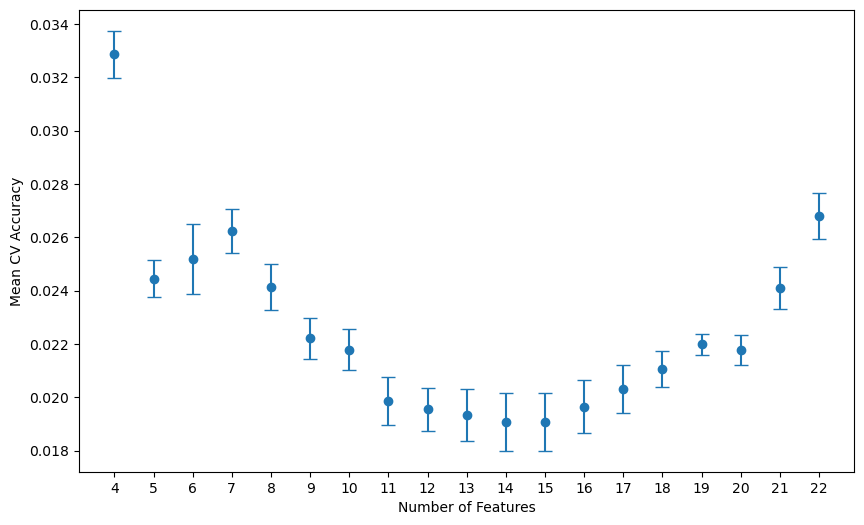

0.02680250783699061
0.024085684430512
0.02178683385579936
0.021995820271682343
0.021055381400208996
0.020323928944618586
0.019644723092998962
0.019070010449320794
0.019070010449320794
0.019331243469174496
0.01954022988505748
0.0198537095088819
0.02178683385579938
0.022204806687565304
0.024137931034482762
0.02622779519331242
0.025182863113897613
0.024451410658307204
0.03286311389759666
0.06222570532915359
0.09597701149425289
0.39691745036572623


0.019070010449320794

In [44]:
plt.figure(figsize=(10, 6))
plt.errorbar(num_features_list[:-3], mean_scores_plot[:-3], yerr=std_scores_plot[:-3], fmt='o', capsize=5)

plt.xlabel('Number of Features')
plt.ylabel('Mean CV Accuracy')
# plt.title('Mean CV Accuracy by Number of Features (with 1 Standard Deviation Error Bars)')
plt.xticks(ticks=num_features_list[:-3], labels=num_features_list[:-3])
plt.savefig("best_feature_selection.png")
plt.show()
for m in mean_scores_plot:
    print(m)

min(mean_scores_plot)

In [49]:
# mean_scores_plot.index(0.019905956112852684)
print(len(best_models[11][0]))
best_model = best_models[11]
best_model[0]

11


17242      BOMBAY
17732      BOMBAY
19053        CALI
8100     BARBUNYA
10964       HOROZ
           ...   
10955       HOROZ
17289      BOMBAY
5192     DERMASON
12172        CALI
235          CALI
Name: Class, Length: 19140, dtype: object

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
k_values = list(range(71, 181, 2))

# Initialize lists to store results
mean_accuracies = []
std_accuracies = []

# Perform cross-validation for each k value
for k in tqdm(k_values, desc="k_values"):
    knn = KNeighborsClassifier(n_neighbors=k)
    # Perform 5-fold cross-validation on the training set
    scores = cross_val_score(knn, X_train[best_model[0]], y_train, cv=5)
    mean_accuracies.append(scores.mean())
    std_accuracies.append(scores.std())



k_values: 100%|████████████████████████████████████████████████████████████████████████| 55/55 [02:05<00:00,  2.29s/it]


In [75]:
k_values = list(range(71, 181, 2))
# Perform cross-validation for each k value
train_acc = []
test_acc = []
for k in k_values:
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train[best_model[0]], y_train)
    y_train_pred = knn.predict(X_train[best_model[0]])
    y_test_pred = knn.predict(X_test[best_model[0]])
    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)
    
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # class_report = classification_report(y_test, y_pred)

    # print(f"Train Accuracy: {train_accuracy}")
    # print(f"Test Accuracy: {test_accuracy}")
    print('Training accuracy:', np.mean(knn.predict(X_train[best_model[0]]) == y_train)*100)
    print('Test accuracy:', np.mean(knn.predict(X_test[best_model[0]]) == y_test)*100)

71
Training accuracy: 98.44305120167189
Test accuracy: 98.51619644723093
73
Training accuracy: 98.4221525600836
Test accuracy: 98.53709508881923
75
Training accuracy: 98.4012539184953
Test accuracy: 98.51619644723093
77
Training accuracy: 98.41692789968653
Test accuracy: 98.47439916405433
79
Training accuracy: 98.38035527690701
Test accuracy: 98.47439916405433
81
Training accuracy: 98.36468129571578
Test accuracy: 98.47439916405433
83
Training accuracy: 98.36468129571578
Test accuracy: 98.49529780564264
85
Training accuracy: 98.36468129571578
Test accuracy: 98.49529780564264
87
Training accuracy: 98.34900731452456
Test accuracy: 98.51619644723093
89
Training accuracy: 98.3385579937304
Test accuracy: 98.47439916405433
91
Training accuracy: 98.3385579937304
Test accuracy: 98.41170323928945
93
Training accuracy: 98.31243469174503
Test accuracy: 98.41170323928945
95
Training accuracy: 98.29153605015674
Test accuracy: 98.39080459770115
97
Training accuracy: 98.3176593521421
Test accuracy: 9

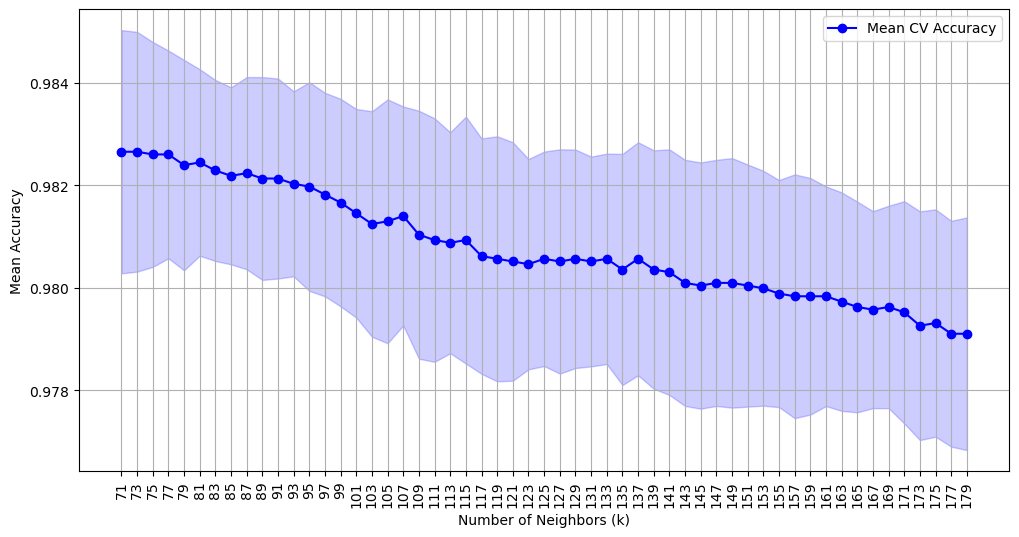

In [119]:
mean_accuracies = np.array(mean_accuracies)
std_accuracies = np.array(std_accuracies)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(k_values, mean_accuracies, label='Mean CV Accuracy', color='b', linestyle='-', marker='o')
plt.fill_between(k_values, mean_accuracies - std_accuracies, mean_accuracies + std_accuracies, color='b', alpha=0.2)
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Accuracy')
# plt.title('Mean Accuracy by Number of Neighbors (k) with Shaded Standard Deviation')
plt.xticks(ticks=k_values, labels=k_values, rotation=90)
plt.grid(True)
plt.legend()
plt.savefig("knn_tune.png")
plt.show()

In [102]:
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, cross_validate

knn = KNeighborsClassifier(n_neighbors=137)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_micro': make_scorer(f1_score, average='micro'),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'f1_weighted': make_scorer(f1_score, average='weighted')
}

# # Perform 5-fold cross-validation on the training data
# y_train_pred = cross_val_predict(knn, X_train, y_train, cv=5, scoring=scoring)

# # Train the classifier on the full training set
# knn.fit(X_train, y_train)

# # Predict on the test set
# y_test_pred = knn.predict(X_test)

# # Calculate metrics on the test set
# accuracy = accuracy_score(y_test, y_test_pred)
# f1_micro = f1_score(y_test, y_test_pred, average='micro')
# f1_macro = f1_score(y_test, y_test_pred, average='macro')
# f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

# # Print the metrics
# print(f'Accuracy: {accuracy}')
# print(f'F1 Score (Micro): {f1_micro}')
# print(f'F1 Score (Macro): {f1_macro}')
# print(f'F1 Score (Weighted): {f1_weighted}')

# print("Classification Report:")
# print(classification_report(y_test, y_test_pred, zero_division=1, digits=5))

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_test_pred))

# Perform 5-fold cross-validation
cv_results = cross_validate(knn, X_train, y_train, cv=5, scoring=scoring)

print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f'F1 Score (Micro): {cv_results['test_f1_micro'].mean()}')
print(f'F1 Score (Macro): {cv_results['test_f1_macro'].mean()}')
print(f'F1 Score (Weighted): {cv_results['test_f1_weighted'].mean()}')
print(f"Accuracy Std Dev: {cv_results['test_accuracy'].std()}")
print(f'F1 Score (Micro) Std Dev: {cv_results['test_f1_micro'].std()}')
print(f'F1 Score (Macro) Std Dev: {cv_results['test_f1_macro'].std()}')
print(f'F1 Score (Weighted) Std Dev: {cv_results['test_f1_weighted'].std()}')

Accuracy: 0.9703239289446186
F1 Score (Micro): 0.9703239289446186
F1 Score (Macro): 0.9703447985154157
F1 Score (Weighted): 0.9704107358271024
Accuracy Std Dev: 0.002357474226265103
F1 Score (Micro) Std Dev: 0.002357474226265103
F1 Score (Macro) Std Dev: 0.002325396341878722
F1 Score (Weighted) Std Dev: 0.002318758684820054


In [120]:
knn = KNeighborsClassifier(n_neighbors=137)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
cls_report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)
cls_report

{'BARBUNYA': {'precision': 0.972768532526475,
  'recall': 0.915954415954416,
  'f1-score': 0.9435069699192957,
  'support': 702.0},
 'BOMBAY': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 676.0},
 'CALI': {'precision': 0.9299867899603699,
  'recall': 0.9723756906077348,
  'f1-score': 0.950708980418636,
  'support': 724.0},
 'DERMASON': {'precision': 0.996996996996997,
  'recall': 0.9895678092399404,
  'f1-score': 0.9932685115931189,
  'support': 671.0},
 'HOROZ': {'precision': 0.9910179640718563,
  'recall': 0.9778434268833087,
  'f1-score': 0.9843866171003718,
  'support': 677.0},
 'SEKER': {'precision': 0.992867332382311,
  'recall': 0.9775280898876404,
  'f1-score': 0.9851380042462845,
  'support': 712.0},
 'SIRA': {'precision': 0.9314024390243902,
  'recall': 0.9807383627608347,
  'f1-score': 0.9554339327599687,
  'support': 623.0},
 'accuracy': 0.9730407523510972,
 'macro avg': {'precision': 0.9735771507089142,
  'recall': 0.9734296850476963,
  'f1-score': 0

# My KNN model

In [138]:
from math import sqrt
from collections import Counter
from tqdm import tqdm
import numpy as np
class My_KNN():
    def __init__(self, k):
        self.k = k

    def euclidean_distance(self, sample_x, sample_y):
        distance = 0.0
        for i in range(len(sample_x)):
            if sample_x[i] != np.nan or sample_y[i] != np.nan:
                distance += (sample_x[i] - sample_y[i])**2
        return sqrt(distance)

    def fit(self, X_train, y_train):
        self.x_train = X_train
        self.y_train = y_train

    def nearest_neighbours(self, test_sample):
        distances = []
        for i in range(len(self.x_train)):
            if self.y_train.iloc[i] != np.nan or self.x_train[i] != np.nan:
                distances.append((self.y_train.iloc[i], self.euclidean_distance(self.x_train.iloc[i], test_sample), i))
        distances.sort(key=lambda x: x[1])
        neighbours = []
        for i in range(self.k):
            neighbours.append(distances[i])
        # neighbours = distances[:self.k]
        labels = []
        distances = []
        indices = []
        for n in neighbours:
            labels.append(n[0])
            distances.append(n[1])
            indices.append(n[2])
        return labels, distances, indices

    def predict(self, test_samples):
        predictions = []
        # i = 0
        for i in tqdm(range(len(test_samples)), desc="Algo"):
            neighbours, distances, index = self.nearest_neighbours(test_samples.iloc[i])
            label = Counter(neighbours).most_common(1)[0][0]
            # print(distances)
            # print(index)
            predictions.append(label)

            # label_weights = {}
            # for label, distance in neighbours:
            #     if distance == 0:
            #         weight = float('inf')
            #     else:
            #         weight = 1 / distance
            #     if label in label_weights:
            #         label_weights[label] += weight
            #     else:
            #         label_weights[label] = weight
            # predicted_label = max(label_weights, key=label_weights.get)
            # predictions.append(predicted_label)
        return predictions

# Classification Tree Implementation

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train
y_test

10441    DERMASON
9305     BARBUNYA
5405        HOROZ
7813         CALI
538          CALI
           ...   
5860        SEKER
11367    DERMASON
11170        CALI
2562     DERMASON
1954         SIRA
Name: Class, Length: 2712, dtype: object

In [80]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

ccp_alpha_values = [i * 0.005 for i in range(0, 21)]
max_depth = [8, 9, 10, 11, 12]
vals = {}
vals_lst = []
cls_reports = []
for depth in tqdm(max_depth, desc="depth"):
    for alpha in tqdm(ccp_alpha_values, desc="alpha"):
        clf = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', ccp_alpha=alpha, max_depth=depth)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy}")
        f1_micro = f1_score(y_test, y_pred, average='micro')
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        
        # Print the metrics
        # print(f'Accuracy: {accuracy}')
        # print(f'F1 Score (Micro): {f1_micro}')
        # print(f'F1 Score (Macro): {f1_macro}')
        # print(f'F1 Score (Weighted): {f1_weighted}')

        vals = {'depth': depth, 'alpha': alpha, 'accuracy': accuracy, 'f1_micro': f1_micro, 'f1_macro': f1_macro, 'f1_weighted': f1_weighted}
        vals_lst.append(vals)
        
        # Generate a classification report
        print("Classification Report:")
        cls = classification_report(y_test, y_pred, zero_division=1, digits=5)
        print(depth)
        print(alpha)
        print(cls)
        cls_reports.append(cls)
        
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

alpha:   5%|███▌                                                                        | 1/21 [00:00<00:07,  2.75it/s]

Accuracy: 0.9775073746312685
Classification Report:
8
0.0
              precision    recall  f1-score   support

    BARBUNYA    0.91093   0.88583   0.89820       254
      BOMBAY    1.00000   0.99065   0.99531       107
        CALI    0.91818   0.94393   0.93088       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97727   0.97543   0.97635       529

    accuracy                        0.97751      2712
   macro avg    0.97234   0.97083   0.97153      2712
weighted avg    0.97754   0.97751   0.97749      2712

Confusion Matrix:
[[225   0  23   0   0   0   6]
 [  1 106   0   0   0   0   0]
 [ 12   0 303   0   0   0   6]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  9   0   4   0   0   0 516]]



alpha:  10%|███████▏                                                                    | 2/21 [00:00<00:06,  2.73it/s]

Accuracy: 0.9727138643067846
Classification Report:
8
0.005
              precision    recall  f1-score   support

    BARBUNYA    0.85932   0.88976   0.87427       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.93069   0.87850   0.90385       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.97271      2712
   macro avg    0.96575   0.96501   0.96522      2712
weighted avg    0.97282   0.97271   0.97264      2712

Confusion Matrix:
[[226   0  16   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 35   0 282   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  2   0   5   0   0   0 522]]



alpha:  14%|██████████▊                                                                 | 3/21 [00:01<00:06,  2.61it/s]

Accuracy: 0.9708702064896755
Classification Report:
8
0.01
              precision    recall  f1-score   support

    BARBUNYA    0.84074   0.89370   0.86641       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.93243   0.85981   0.89465       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.97087      2712
   macro avg    0.96335   0.96290   0.96279      2712
weighted avg    0.97129   0.97087   0.97081      2712

Confusion Matrix:
[[227   0  15   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 41   0 276   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  2   0   5   0   0   0 522]]



alpha:  19%|██████████████▍                                                             | 4/21 [00:01<00:06,  2.71it/s]

Accuracy: 0.9668141592920354
Classification Report:
8
0.015
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  24%|██████████████████                                                          | 5/21 [00:01<00:05,  2.74it/s]

Accuracy: 0.9668141592920354
Classification Report:
8
0.02
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  29%|█████████████████████▋                                                      | 6/21 [00:02<00:05,  2.75it/s]

Accuracy: 0.9668141592920354
Classification Report:
8
0.025
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  33%|█████████████████████████▎                                                  | 7/21 [00:02<00:05,  2.75it/s]

Accuracy: 0.9668141592920354
Classification Report:
8
0.03
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  38%|████████████████████████████▉                                               | 8/21 [00:02<00:04,  2.75it/s]

Accuracy: 0.9668141592920354
Classification Report:
8
0.035
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  43%|████████████████████████████████▌                                           | 9/21 [00:03<00:04,  2.72it/s]

Accuracy: 0.9668141592920354
Classification Report:
8
0.04
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  48%|███████████████████████████████████▋                                       | 10/21 [00:03<00:04,  2.75it/s]

Accuracy: 0.9668141592920354
Classification Report:
8
0.045
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  52%|███████████████████████████████████████▎                                   | 11/21 [00:04<00:03,  2.75it/s]

Accuracy: 0.9564896755162242
Classification Report:
8
0.05
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  57%|██████████████████████████████████████████▊                                | 12/21 [00:04<00:03,  2.77it/s]

Accuracy: 0.9564896755162242
Classification Report:
8
0.055
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  62%|██████████████████████████████████████████████▍                            | 13/21 [00:04<00:03,  2.65it/s]

Accuracy: 0.9564896755162242
Classification Report:
8
0.06
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  67%|██████████████████████████████████████████████████                         | 14/21 [00:05<00:02,  2.71it/s]

Accuracy: 0.9564896755162242
Classification Report:
8
0.065
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  71%|█████████████████████████████████████████████████████▌                     | 15/21 [00:05<00:02,  2.74it/s]

Accuracy: 0.9564896755162242
Classification Report:
8
0.07
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  76%|█████████████████████████████████████████████████████████▏                 | 16/21 [00:05<00:01,  2.78it/s]

Accuracy: 0.9564896755162242
Classification Report:
8
0.075
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  81%|████████████████████████████████████████████████████████████▋              | 17/21 [00:06<00:01,  2.73it/s]

Accuracy: 0.9564896755162242
Classification Report:
8
0.08
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  86%|████████████████████████████████████████████████████████████████▎          | 18/21 [00:06<00:01,  2.75it/s]

Accuracy: 0.9564896755162242
Classification Report:
8
0.085
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  90%|███████████████████████████████████████████████████████████████████▊       | 19/21 [00:06<00:00,  2.79it/s]

Accuracy: 0.9564896755162242
Classification Report:
8
0.09
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  95%|███████████████████████████████████████████████████████████████████████▍   | 20/21 [00:07<00:00,  2.80it/s]

Accuracy: 0.9564896755162242
Classification Report:
8
0.095
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



depth:  20%|███████████████▍                                                             | 1/5 [00:07<00:30,  7.65s/it]

Accuracy: 0.9022861356932154
Classification Report:
8
0.1
              precision    recall  f1-score   support

    BARBUNYA    1.00000   0.00000   0.00000       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.56007   0.98754   0.71477       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.90229      2712
   macro avg    0.93290   0.85347   0.81332      2712
weighted avg    0.94213   0.90229   0.86838      2712

Confusion Matrix:
[[  0   0 242   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [  0   0 317   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:   5%|███▌                                                                        | 1/21 [00:00<00:07,  2.85it/s]

Accuracy: 0.9775073746312685
Classification Report:
9
0.0
              precision    recall  f1-score   support

    BARBUNYA    0.90726   0.88583   0.89641       254
      BOMBAY    1.00000   0.99065   0.99531       107
        CALI    0.91892   0.95327   0.93578       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97901   0.96975   0.97436       529

    accuracy                        0.97751      2712
   macro avg    0.97217   0.97136   0.97169      2712
weighted avg    0.97762   0.97751   0.97751      2712

Confusion Matrix:
[[225   0  22   0   0   0   7]
 [  1 106   0   0   0   0   0]
 [ 11   0 306   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [ 11   0   5   0   0   0 513]]



alpha:  10%|███████▏                                                                    | 2/21 [00:00<00:06,  2.83it/s]

Accuracy: 0.9727138643067846
Classification Report:
9
0.005
              precision    recall  f1-score   support

    BARBUNYA    0.85932   0.88976   0.87427       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.93069   0.87850   0.90385       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.97271      2712
   macro avg    0.96575   0.96501   0.96522      2712
weighted avg    0.97282   0.97271   0.97264      2712

Confusion Matrix:
[[226   0  16   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 35   0 282   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  2   0   5   0   0   0 522]]



alpha:  14%|██████████▊                                                                 | 3/21 [00:01<00:06,  2.81it/s]

Accuracy: 0.9708702064896755
Classification Report:
9
0.01
              precision    recall  f1-score   support

    BARBUNYA    0.84074   0.89370   0.86641       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.93243   0.85981   0.89465       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.97087      2712
   macro avg    0.96335   0.96290   0.96279      2712
weighted avg    0.97129   0.97087   0.97081      2712

Confusion Matrix:
[[227   0  15   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 41   0 276   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  2   0   5   0   0   0 522]]



alpha:  19%|██████████████▍                                                             | 4/21 [00:01<00:06,  2.83it/s]

Accuracy: 0.9668141592920354
Classification Report:
9
0.015
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  24%|██████████████████                                                          | 5/21 [00:01<00:05,  2.81it/s]

Accuracy: 0.9668141592920354
Classification Report:
9
0.02
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  29%|█████████████████████▋                                                      | 6/21 [00:02<00:05,  2.80it/s]

Accuracy: 0.9668141592920354
Classification Report:
9
0.025
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  33%|█████████████████████████▎                                                  | 7/21 [00:02<00:05,  2.79it/s]

Accuracy: 0.9668141592920354
Classification Report:
9
0.03
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  38%|████████████████████████████▉                                               | 8/21 [00:02<00:04,  2.80it/s]

Accuracy: 0.9668141592920354
Classification Report:
9
0.035
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  43%|████████████████████████████████▌                                           | 9/21 [00:03<00:04,  2.77it/s]

Accuracy: 0.9668141592920354
Classification Report:
9
0.04
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  48%|███████████████████████████████████▋                                       | 10/21 [00:03<00:03,  2.81it/s]

Accuracy: 0.9668141592920354
Classification Report:
9
0.045
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  52%|███████████████████████████████████████▎                                   | 11/21 [00:03<00:03,  2.81it/s]

Accuracy: 0.9564896755162242
Classification Report:
9
0.05
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  57%|██████████████████████████████████████████▊                                | 12/21 [00:04<00:03,  2.81it/s]

Accuracy: 0.9564896755162242
Classification Report:
9
0.055
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  62%|██████████████████████████████████████████████▍                            | 13/21 [00:04<00:02,  2.80it/s]

Accuracy: 0.9564896755162242
Classification Report:
9
0.06
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  67%|██████████████████████████████████████████████████                         | 14/21 [00:05<00:02,  2.73it/s]

Accuracy: 0.9564896755162242
Classification Report:
9
0.065
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  71%|█████████████████████████████████████████████████████▌                     | 15/21 [00:05<00:02,  2.67it/s]

Accuracy: 0.9564896755162242
Classification Report:
9
0.07
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  76%|█████████████████████████████████████████████████████████▏                 | 16/21 [00:05<00:01,  2.71it/s]

Accuracy: 0.9564896755162242
Classification Report:
9
0.075
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  81%|████████████████████████████████████████████████████████████▋              | 17/21 [00:06<00:01,  2.75it/s]

Accuracy: 0.9564896755162242
Classification Report:
9
0.08
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  86%|████████████████████████████████████████████████████████████████▎          | 18/21 [00:06<00:01,  2.77it/s]

Accuracy: 0.9564896755162242
Classification Report:
9
0.085
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  90%|███████████████████████████████████████████████████████████████████▊       | 19/21 [00:06<00:00,  2.77it/s]

Accuracy: 0.9564896755162242
Classification Report:
9
0.09
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  95%|███████████████████████████████████████████████████████████████████████▍   | 20/21 [00:07<00:00,  2.73it/s]

Accuracy: 0.9564896755162242
Classification Report:
9
0.095
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



depth:  40%|██████████████████████████████▊                                              | 2/5 [00:15<00:22,  7.61s/it]

Accuracy: 0.9022861356932154
Classification Report:
9
0.1
              precision    recall  f1-score   support

    BARBUNYA    1.00000   0.00000   0.00000       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.56007   0.98754   0.71477       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.90229      2712
   macro avg    0.93290   0.85347   0.81332      2712
weighted avg    0.94213   0.90229   0.86838      2712

Confusion Matrix:
[[  0   0 242   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [  0   0 317   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:   5%|███▌                                                                        | 1/21 [00:00<00:07,  2.81it/s]

Accuracy: 0.9782448377581121
Classification Report:
10
0.0
              precision    recall  f1-score   support

    BARBUNYA    0.91165   0.89370   0.90258       254
      BOMBAY    1.00000   0.99065   0.99531       107
        CALI    0.92901   0.93769   0.93333       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97368   0.97921   0.97644       529

    accuracy                        0.97824      2712
   macro avg    0.97348   0.97161   0.97252      2712
weighted avg    0.97819   0.97824   0.97820      2712

Confusion Matrix:
[[227   0  20   0   0   0   7]
 [  1 106   0   0   0   0   0]
 [ 13   0 301   0   0   0   7]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  8   0   3   0   0   0 518]]



alpha:  10%|███████▏                                                                    | 2/21 [00:00<00:06,  2.81it/s]

Accuracy: 0.9727138643067846
Classification Report:
10
0.005
              precision    recall  f1-score   support

    BARBUNYA    0.85932   0.88976   0.87427       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.93069   0.87850   0.90385       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.97271      2712
   macro avg    0.96575   0.96501   0.96522      2712
weighted avg    0.97282   0.97271   0.97264      2712

Confusion Matrix:
[[226   0  16   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 35   0 282   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  2   0   5   0   0   0 522]]



alpha:  14%|██████████▊                                                                 | 3/21 [00:01<00:06,  2.78it/s]

Accuracy: 0.9708702064896755
Classification Report:
10
0.01
              precision    recall  f1-score   support

    BARBUNYA    0.84074   0.89370   0.86641       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.93243   0.85981   0.89465       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.97087      2712
   macro avg    0.96335   0.96290   0.96279      2712
weighted avg    0.97129   0.97087   0.97081      2712

Confusion Matrix:
[[227   0  15   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 41   0 276   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  2   0   5   0   0   0 522]]



alpha:  19%|██████████████▍                                                             | 4/21 [00:01<00:06,  2.77it/s]

Accuracy: 0.9668141592920354
Classification Report:
10
0.015
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  24%|██████████████████                                                          | 5/21 [00:01<00:05,  2.73it/s]

Accuracy: 0.9668141592920354
Classification Report:
10
0.02
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  29%|█████████████████████▋                                                      | 6/21 [00:02<00:05,  2.73it/s]

Accuracy: 0.9668141592920354
Classification Report:
10
0.025
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  33%|█████████████████████████▎                                                  | 7/21 [00:02<00:05,  2.69it/s]

Accuracy: 0.9668141592920354
Classification Report:
10
0.03
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  38%|████████████████████████████▉                                               | 8/21 [00:02<00:04,  2.71it/s]

Accuracy: 0.9668141592920354
Classification Report:
10
0.035
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  43%|████████████████████████████████▌                                           | 9/21 [00:03<00:04,  2.73it/s]

Accuracy: 0.9668141592920354
Classification Report:
10
0.04
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  48%|███████████████████████████████████▋                                       | 10/21 [00:03<00:04,  2.74it/s]

Accuracy: 0.9668141592920354
Classification Report:
10
0.045
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  52%|███████████████████████████████████████▎                                   | 11/21 [00:04<00:03,  2.73it/s]

Accuracy: 0.9564896755162242
Classification Report:
10
0.05
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  57%|██████████████████████████████████████████▊                                | 12/21 [00:04<00:03,  2.70it/s]

Accuracy: 0.9564896755162242
Classification Report:
10
0.055
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  62%|██████████████████████████████████████████████▍                            | 13/21 [00:04<00:03,  2.66it/s]

Accuracy: 0.9564896755162242
Classification Report:
10
0.06
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  67%|██████████████████████████████████████████████████                         | 14/21 [00:05<00:02,  2.63it/s]

Accuracy: 0.9564896755162242
Classification Report:
10
0.065
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  71%|█████████████████████████████████████████████████████▌                     | 15/21 [00:05<00:02,  2.60it/s]

Accuracy: 0.9564896755162242
Classification Report:
10
0.07
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  76%|█████████████████████████████████████████████████████████▏                 | 16/21 [00:05<00:01,  2.57it/s]

Accuracy: 0.9564896755162242
Classification Report:
10
0.075
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  81%|████████████████████████████████████████████████████████████▋              | 17/21 [00:06<00:01,  2.55it/s]

Accuracy: 0.9564896755162242
Classification Report:
10
0.08
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  86%|████████████████████████████████████████████████████████████████▎          | 18/21 [00:06<00:01,  2.54it/s]

Accuracy: 0.9564896755162242
Classification Report:
10
0.085
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  90%|███████████████████████████████████████████████████████████████████▊       | 19/21 [00:07<00:00,  2.56it/s]

Accuracy: 0.9564896755162242
Classification Report:
10
0.09
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  95%|███████████████████████████████████████████████████████████████████████▍   | 20/21 [00:07<00:00,  2.57it/s]

Accuracy: 0.9564896755162242
Classification Report:
10
0.095
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



depth:  60%|██████████████████████████████████████████████▏                              | 3/5 [00:23<00:15,  7.76s/it]

Accuracy: 0.9022861356932154
Classification Report:
10
0.1
              precision    recall  f1-score   support

    BARBUNYA    1.00000   0.00000   0.00000       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.56007   0.98754   0.71477       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.90229      2712
   macro avg    0.93290   0.85347   0.81332      2712
weighted avg    0.94213   0.90229   0.86838      2712

Confusion Matrix:
[[  0   0 242   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [  0   0 317   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:   5%|███▌                                                                        | 1/21 [00:00<00:07,  2.53it/s]

Accuracy: 0.9775073746312685
Classification Report:
11
0.0
              precision    recall  f1-score   support

    BARBUNYA    0.88846   0.90945   0.89883       254
      BOMBAY    1.00000   0.99065   0.99531       107
        CALI    0.94231   0.91589   0.92891       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97373   0.98110   0.97740       529

    accuracy                        0.97751      2712
   macro avg    0.97207   0.97101   0.97149      2712
weighted avg    0.97760   0.97751   0.97752      2712

Confusion Matrix:
[[231   0  16   0   0   0   7]
 [  1 106   0   0   0   0   0]
 [ 20   0 294   0   0   0   7]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  8   0   2   0   0   0 519]]



alpha:  10%|███████▏                                                                    | 2/21 [00:00<00:07,  2.68it/s]

Accuracy: 0.9727138643067846
Classification Report:
11
0.005
              precision    recall  f1-score   support

    BARBUNYA    0.85932   0.88976   0.87427       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.93069   0.87850   0.90385       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.97271      2712
   macro avg    0.96575   0.96501   0.96522      2712
weighted avg    0.97282   0.97271   0.97264      2712

Confusion Matrix:
[[226   0  16   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 35   0 282   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  2   0   5   0   0   0 522]]



alpha:  14%|██████████▊                                                                 | 3/21 [00:01<00:06,  2.74it/s]

Accuracy: 0.9708702064896755
Classification Report:
11
0.01
              precision    recall  f1-score   support

    BARBUNYA    0.84074   0.89370   0.86641       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.93243   0.85981   0.89465       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.97087      2712
   macro avg    0.96335   0.96290   0.96279      2712
weighted avg    0.97129   0.97087   0.97081      2712

Confusion Matrix:
[[227   0  15   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 41   0 276   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  2   0   5   0   0   0 522]]



alpha:  19%|██████████████▍                                                             | 4/21 [00:01<00:06,  2.75it/s]

Accuracy: 0.9668141592920354
Classification Report:
11
0.015
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  24%|██████████████████                                                          | 5/21 [00:01<00:05,  2.77it/s]

Accuracy: 0.9668141592920354
Classification Report:
11
0.02
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  29%|█████████████████████▋                                                      | 6/21 [00:02<00:05,  2.79it/s]

Accuracy: 0.9668141592920354
Classification Report:
11
0.025
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  33%|█████████████████████████▎                                                  | 7/21 [00:02<00:05,  2.80it/s]

Accuracy: 0.9668141592920354
Classification Report:
11
0.03
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  38%|████████████████████████████▉                                               | 8/21 [00:02<00:04,  2.79it/s]

Accuracy: 0.9668141592920354
Classification Report:
11
0.035
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  43%|████████████████████████████████▌                                           | 9/21 [00:03<00:04,  2.80it/s]

Accuracy: 0.9668141592920354
Classification Report:
11
0.04
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  48%|███████████████████████████████████▋                                       | 10/21 [00:03<00:03,  2.80it/s]

Accuracy: 0.9668141592920354
Classification Report:
11
0.045
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  52%|███████████████████████████████████████▎                                   | 11/21 [00:03<00:03,  2.81it/s]

Accuracy: 0.9564896755162242
Classification Report:
11
0.05
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  57%|██████████████████████████████████████████▊                                | 12/21 [00:04<00:03,  2.80it/s]

Accuracy: 0.9564896755162242
Classification Report:
11
0.055
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  62%|██████████████████████████████████████████████▍                            | 13/21 [00:04<00:02,  2.81it/s]

Accuracy: 0.9564896755162242
Classification Report:
11
0.06
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  67%|██████████████████████████████████████████████████                         | 14/21 [00:05<00:02,  2.80it/s]

Accuracy: 0.9564896755162242
Classification Report:
11
0.065
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  71%|█████████████████████████████████████████████████████▌                     | 15/21 [00:05<00:02,  2.81it/s]

Accuracy: 0.9564896755162242
Classification Report:
11
0.07
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  76%|█████████████████████████████████████████████████████████▏                 | 16/21 [00:05<00:01,  2.81it/s]

Accuracy: 0.9564896755162242
Classification Report:
11
0.075
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  81%|████████████████████████████████████████████████████████████▋              | 17/21 [00:06<00:01,  2.82it/s]

Accuracy: 0.9564896755162242
Classification Report:
11
0.08
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  86%|████████████████████████████████████████████████████████████████▎          | 18/21 [00:06<00:01,  2.80it/s]

Accuracy: 0.9564896755162242
Classification Report:
11
0.085
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  90%|███████████████████████████████████████████████████████████████████▊       | 19/21 [00:06<00:00,  2.83it/s]

Accuracy: 0.9564896755162242
Classification Report:
11
0.09
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  95%|███████████████████████████████████████████████████████████████████████▍   | 20/21 [00:07<00:00,  2.70it/s]

Accuracy: 0.9564896755162242
Classification Report:
11
0.095
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



depth:  80%|█████████████████████████████████████████████████████████████▌               | 4/5 [00:30<00:07,  7.70s/it]

Accuracy: 0.9022861356932154
Classification Report:
11
0.1
              precision    recall  f1-score   support

    BARBUNYA    1.00000   0.00000   0.00000       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.56007   0.98754   0.71477       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.90229      2712
   macro avg    0.93290   0.85347   0.81332      2712
weighted avg    0.94213   0.90229   0.86838      2712

Confusion Matrix:
[[  0   0 242   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [  0   0 317   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:   5%|███▌                                                                        | 1/21 [00:00<00:08,  2.33it/s]

Accuracy: 0.9782448377581121
Classification Report:
12
0.0
              precision    recall  f1-score   support

    BARBUNYA    0.89189   0.90945   0.90058       254
      BOMBAY    1.00000   0.99065   0.99531       107
        CALI    0.94286   0.92523   0.93396       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97552   0.97921   0.97736       529

    accuracy                        0.97824      2712
   macro avg    0.97290   0.97208   0.97246      2712
weighted avg    0.97834   0.97824   0.97827      2712

Confusion Matrix:
[[231   0  16   0   0   0   7]
 [  1 106   0   0   0   0   0]
 [ 18   0 297   0   0   0   6]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  9   0   2   0   0   0 518]]



alpha:  10%|███████▏                                                                    | 2/21 [00:00<00:07,  2.46it/s]

Accuracy: 0.9727138643067846
Classification Report:
12
0.005
              precision    recall  f1-score   support

    BARBUNYA    0.85932   0.88976   0.87427       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.93069   0.87850   0.90385       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.97271      2712
   macro avg    0.96575   0.96501   0.96522      2712
weighted avg    0.97282   0.97271   0.97264      2712

Confusion Matrix:
[[226   0  16   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 35   0 282   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  2   0   5   0   0   0 522]]



alpha:  14%|██████████▊                                                                 | 3/21 [00:01<00:07,  2.53it/s]

Accuracy: 0.9708702064896755
Classification Report:
12
0.01
              precision    recall  f1-score   support

    BARBUNYA    0.84074   0.89370   0.86641       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.93243   0.85981   0.89465       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.97087      2712
   macro avg    0.96335   0.96290   0.96279      2712
weighted avg    0.97129   0.97087   0.97081      2712

Confusion Matrix:
[[227   0  15   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 41   0 276   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  2   0   5   0   0   0 522]]



alpha:  19%|██████████████▍                                                             | 4/21 [00:01<00:06,  2.61it/s]

Accuracy: 0.9668141592920354
Classification Report:
12
0.015
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  24%|██████████████████                                                          | 5/21 [00:01<00:06,  2.54it/s]

Accuracy: 0.9668141592920354
Classification Report:
12
0.02
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  29%|█████████████████████▋                                                      | 6/21 [00:02<00:05,  2.63it/s]

Accuracy: 0.9668141592920354
Classification Report:
12
0.025
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  33%|█████████████████████████▎                                                  | 7/21 [00:02<00:05,  2.58it/s]

Accuracy: 0.9668141592920354
Classification Report:
12
0.03
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  38%|████████████████████████████▉                                               | 8/21 [00:03<00:05,  2.58it/s]

Accuracy: 0.9668141592920354
Classification Report:
12
0.035
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  43%|████████████████████████████████▌                                           | 9/21 [00:03<00:04,  2.61it/s]

Accuracy: 0.9668141592920354
Classification Report:
12
0.04
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  48%|███████████████████████████████████▋                                       | 10/21 [00:03<00:04,  2.63it/s]

Accuracy: 0.9668141592920354
Classification Report:
12
0.045
              precision    recall  f1-score   support

    BARBUNYA    0.83984   0.84646   0.84314       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.89355   0.86293   0.87797       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.96681      2712
   macro avg    0.95766   0.95659   0.95708      2712
weighted avg    0.96660   0.96681   0.96666      2712

Confusion Matrix:
[[215   0  27   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 40   0 277   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  1   0   6   0   0   0 522]]



alpha:  52%|███████████████████████████████████████▎                                   | 11/21 [00:04<00:03,  2.66it/s]

Accuracy: 0.9564896755162242
Classification Report:
12
0.05
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  57%|██████████████████████████████████████████▊                                | 12/21 [00:04<00:03,  2.67it/s]

Accuracy: 0.9564896755162242
Classification Report:
12
0.055
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  62%|██████████████████████████████████████████████▍                            | 13/21 [00:04<00:03,  2.66it/s]

Accuracy: 0.9564896755162242
Classification Report:
12
0.06
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  67%|██████████████████████████████████████████████████                         | 14/21 [00:05<00:02,  2.63it/s]

Accuracy: 0.9564896755162242
Classification Report:
12
0.065
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  71%|█████████████████████████████████████████████████████▌                     | 15/21 [00:05<00:02,  2.64it/s]

Accuracy: 0.9564896755162242
Classification Report:
12
0.07
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  76%|█████████████████████████████████████████████████████████▏                 | 16/21 [00:06<00:01,  2.72it/s]

Accuracy: 0.9564896755162242
Classification Report:
12
0.075
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  81%|████████████████████████████████████████████████████████████▋              | 17/21 [00:06<00:01,  2.71it/s]

Accuracy: 0.9564896755162242
Classification Report:
12
0.08
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  86%|████████████████████████████████████████████████████████████████▎          | 18/21 [00:06<00:01,  2.74it/s]

Accuracy: 0.9564896755162242
Classification Report:
12
0.085
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  90%|███████████████████████████████████████████████████████████████████▊       | 19/21 [00:07<00:00,  2.74it/s]

Accuracy: 0.9564896755162242
Classification Report:
12
0.09
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



alpha:  95%|███████████████████████████████████████████████████████████████████████▍   | 20/21 [00:07<00:00,  2.77it/s]

Accuracy: 0.9564896755162242
Classification Report:
12
0.095
              precision    recall  f1-score   support

    BARBUNYA    0.84507   0.70866   0.77088       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.80453   0.88474   0.84273       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.95649      2712
   macro avg    0.94569   0.94002   0.94172      2712
weighted avg    0.95655   0.95649   0.95572      2712

Confusion Matrix:
[[180   0  62   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [ 33   0 284   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]



depth: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [00:38<00:00,  7.73s/it]

Accuracy: 0.9022861356932154
Classification Report:
12
0.1
              precision    recall  f1-score   support

    BARBUNYA    1.00000   0.00000   0.00000       254
      BOMBAY    1.00000   1.00000   1.00000       107
        CALI    0.56007   0.98754   0.71477       321
    DERMASON    1.00000   1.00000   1.00000       728
       HOROZ    1.00000   1.00000   1.00000       385
       SEKER    1.00000   1.00000   1.00000       388
        SIRA    0.97026   0.98677   0.97844       529

    accuracy                        0.90229      2712
   macro avg    0.93290   0.85347   0.81332      2712
weighted avg    0.94213   0.90229   0.86838      2712

Confusion Matrix:
[[  0   0 242   0   0   0  12]
 [  0 107   0   0   0   0   0]
 [  0   0 317   0   0   0   4]
 [  0   0   0 728   0   0   0]
 [  0   0   0   0 385   0   0]
 [  0   0   0   0   0 388   0]
 [  0   0   7   0   0   0 522]]


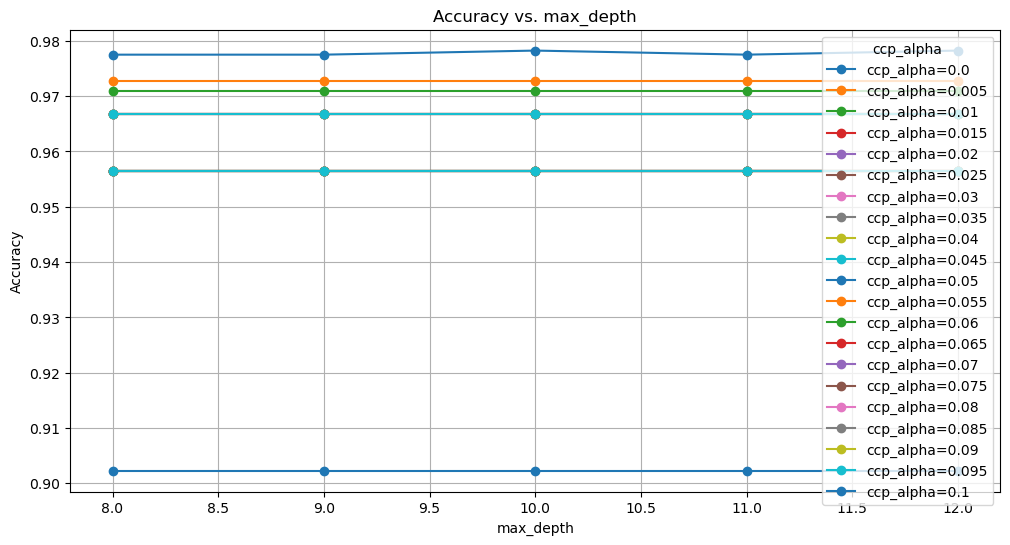

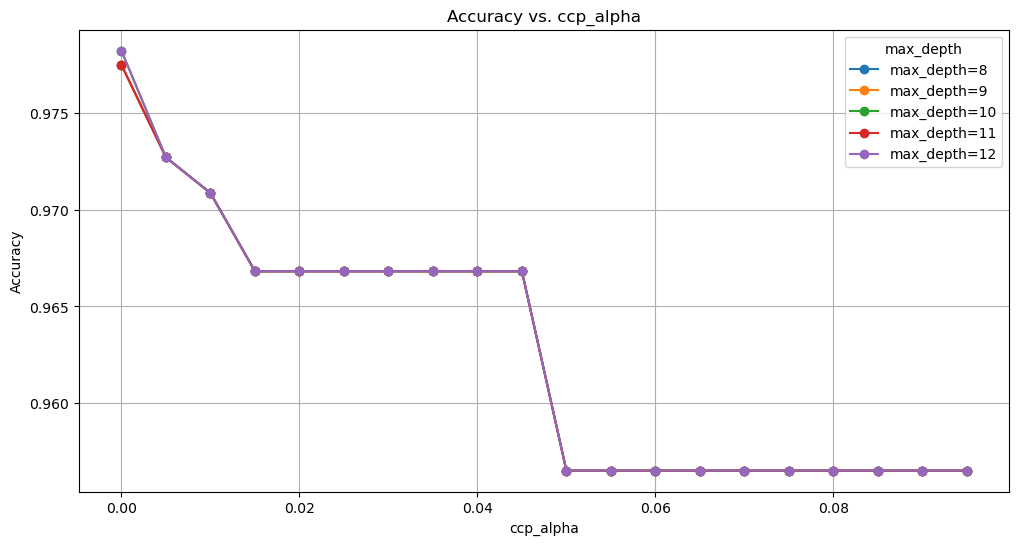

In [88]:
# Create a DataFrame from the list of dictionaries
accuracy_data = pd.DataFrame(vals_lst)

# Create a line plot for accuracy vs. max_depth
plt.figure(figsize=(12, 6))

# Plot accuracy for different max_depth values with varying ccp_alpha
for alpha in ccp_alpha_values:
    subset = accuracy_data[accuracy_data['alpha'] == alpha]
    plt.plot(subset['depth'], subset['accuracy'], marker='o', label=f'ccp_alpha={alpha}')

plt.title('Accuracy vs. max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend(title='ccp_alpha')
plt.grid(True)
plt.savefig("sklearnTuneDepth.png")
plt.show()

# Create a line plot for accuracy vs. ccp_alpha
plt.figure(figsize=(12, 6))

# Plot accuracy for different max_depth values with varying ccp_alpha
for depth in max_depth:
    subset = accuracy_data[accuracy_data['depth'] == depth][:-1]
    plt.plot(subset['alpha'], subset['accuracy'], marker='o', label=f'max_depth={depth}')

plt.title('Accuracy vs. ccp_alpha')
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.legend(title='max_depth')
plt.grid(True)
plt.savefig("sklearnTuneAlpha.png")
plt.show()

# Final comparison

In [105]:
clf = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', ccp_alpha=0.02, max_depth=10)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_micro': make_scorer(f1_score, average='micro'),
    'f1_macro': make_scorer(f1_score, average='macro'),
    'f1_weighted': make_scorer(f1_score, average='weighted')
}

cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=scoring)

print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
print(f'F1 Score (Micro): {cv_results['test_f1_micro'].mean()}')
print(f'F1 Score (Macro): {cv_results['test_f1_macro'].mean()}')
print(f'F1 Score (Weighted): {cv_results['test_f1_weighted'].mean()}')
print(f"Accuracy Std Dev: {cv_results['test_accuracy'].std()}")
print(f'F1 Score (Micro) Std Dev: {cv_results['test_f1_micro'].std()}')
print(f'F1 Score (Macro) Std Dev: {cv_results['test_f1_macro'].std()}')
print(f'F1 Score (Weighted) Std Dev: {cv_results['test_f1_weighted'].std()}')

Accuracy: 0.9680087874171666
F1 Score (Micro): 0.9680087874171666
F1 Score (Macro): 0.9590479414081174
F1 Score (Weighted): 0.9677039214689864
Accuracy Std Dev: 0.007507557978520391
F1 Score (Micro) Std Dev: 0.007507557978520391
F1 Score (Macro) Std Dev: 0.009797793631816074
F1 Score (Weighted) Std Dev: 0.0077021236731351405


In [111]:
clf = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', ccp_alpha=0.02, max_depth=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
cls_report = classification_report(y_test, y_pred, zero_division=1, output_dict=True)
cls_report

{'BARBUNYA': {'precision': 0.83984375,
  'recall': 0.8464566929133859,
  'f1-score': 0.8431372549019608,
  'support': 254.0},
 'BOMBAY': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 107.0},
 'CALI': {'precision': 0.8935483870967742,
  'recall': 0.8629283489096573,
  'f1-score': 0.8779714738510301,
  'support': 321.0},
 'DERMASON': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 728.0},
 'HOROZ': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 385.0},
 'SEKER': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 388.0},
 'SIRA': {'precision': 0.9702602230483272,
  'recall': 0.9867674858223062,
  'f1-score': 0.9784442361761949,
  'support': 529.0},
 'accuracy': 0.9668141592920354,
 'macro avg': {'precision': 0.9576646228778716,
  'recall': 0.95659321823505,
  'f1-score': 0.9570789949898837,
  'support': 2712.0},
 'weighted avg': {'precision': 0.9665991898048043,
  'recall': 0.9668141592920354,
  'f1-score': 0.966660290113